In [1]:
import os, sys
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
print("Project root added to sys.path:", ROOT)

from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
import jax.numpy as jnp
from utils.artifacts_io import latest_run_dir, load_manifest, npz
from notebooks.utils_plotting import aggregate_over_seeds

Project root added to sys.path: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments


# **Experiment: Empirical NTK Drift and the Onset of the Lazy Regime**

## **Goal**

The goal of this experiment is to determine **when** and **whether** a finite-width neural network enters the **lazy regime**, where its training dynamics become equivalent to **kernel regression using a fixed Neural Tangent Kernel (NTK)**.

We specifically want to test:

1. **Does the empirical NTK on the training set become approximately constant after some training time?**
2. **If so, do the network predictions from that point onward match kernel regression with the frozen NTK?**
3. **Does the time at which the NTK stops changing coincide with a plateau in the training loss?**

This provides a clean, finite-width test of the lazy-training hypothesis.

---

## **Setup**

We consider a regression task defined on the **unit circle**.  
The target function is a **Fourier mixture**:

$$
f^*(\gamma) = \sum_k a_k \cos(k\gamma + \phi_k).
$$

- The evaluation grid is a **dense, uniform sampling** of the circle.
- The training set consists of **random points** sampled from the same circle.
- We train fully-connected ReLU MLPs of multiple widths using SGD.

---

## **What We Log**

At regular intervals (every `eval_every` steps), we take **NTK snapshots**.

### **1. Training-set NTK**

$$
K_{\text{train,train}}(t) \in \mathbb{R}^{M_{\text{train}} \times M_{\text{train}}}.
$$

This governs linearized dynamics on the training set.  
We use it to compute NTK drift:

$$
\Delta_K(t) = \|K(t) - K(0)\|_F.
$$

---

### **2. Eval–Train NTK**

Needed for kernel regression predictions:

$$
K_{\text{eval,train}}(t) \in \mathbb{R}^{N_{\text{eval}} \times M_{\text{train}}}.
$$

Given a frozen NTK at time $t^*$, the kernel regression predictor is:

$$
f_{\mathrm{KR}}(\gamma)
= K_{\text{eval,train}}(t^*)
\bigl(K_{\text{train,train}}(t^*) + \lambda I\bigr)^{-1} y_{\text{train}}.
$$

---

### **3. Model Predictions**

At each snapshot $f_{\text{net}}(\gamma, t)$ recorded on the dense eval grid.

Allows direct comparison 
$f_{\text{net}}(\gamma, t_{\text{final}}) 
\quad \text{vs} \quad
f_{\mathrm{KR}}(\gamma; K(t^*)).
$

---

### **4. Snapshot Training Loss**

Recorded at snapshot steps:

$$
L(t) = \frac{1}{M_{\text{train}}}
\sum_{i=1}^{M_{\text{train}}}
\bigl( f_{\text{net}}(x_i, t) - y_i \bigr)^2.
$$

This aligns loss with NTK drift.

---

## **Central Hypothesis**

If a network enters the **lazy regime**, we expect:

1. **NTK freeze**:  
   $$
   \Delta_K(t) \approx 0 \;\; \text{for all } t > t_{\text{freeze}}.
   $$

2. **Kernel-regression tracking**:  
   For $t > t_{\text{freeze}}$,
   $$
   f_{\text{net}}(\gamma, t) \approx
   f_{\mathrm{KR}}(\gamma; K(t_{\text{freeze}})).
   $$

3. **Loss plateau**:  
   The freeze time often corresponds to a slowdown or plateau in the training loss.

---

## **Width Sweep**

We repeat the entire experiment for several widths:

$$
W \in \{100, 512, 1024, 2048, 10000\},
$$

across multiple seeds.

This allows us to study:

- how NTK drift scales with width,
- whether wider networks enter the lazy regime earlier,
- how finite-width deviations behave relative to kernel regression.

---

## **Saved Artifacts**

For each width and seed, we save:

- $K_{\text{train,train}}(t)$ snapshots  
- $K_{\text{eval,train}}(t)$ snapshots  
- $f_{\text{net}}(\gamma, t)$ predictions  
- $(\text{seed}, \text{step})$ metadata for each snapshot  
- loss snapshots  
- the dataset (train + eval + Fourier parameters)

These allow reconstruction of:

- NTK drift curves  
- kernel regression solutions  
- comparison of GD vs KR  
- identification of the NTK freeze time  

---

## **Analysis Outline**

### **1. NTK Drift Curve**

Compute normalized drift:

$$
\rho(t) = 
\frac{\|K(t) - K(0)\|_F}{\|K(0)\|_F}.
$$

Freeze time $t_{\text{freeze}}$ is when $\rho(t)$ first becomes flat.

---

### **2. Kernel Regression at Freeze Time**

Solve:

$$
\alpha = \bigl(K_{\text{train,train}}(t^*) + \lambda I\bigr)^{-1} y_{\text{train}},
$$

Compute:

$$
f_{\mathrm{KR}} = K_{\text{eval,train}}(t^*) \,\alpha.
$$

Compare to network:

$$
\| f_{\text{net}}(\gamma, t_{\text{final}}) - f_{\mathrm{KR}} \|_2.
$$

---

### **3. Compare Loss Plateau with NTK Freeze**

Plot:

- snapshot loss $L(t)$  
- normalized kernel drift $\rho(t)$  

Check if NTK stabilization corresponds to optimization slowdown.

---

## **Outcome**

If wide networks quickly freeze their NTK and match kernel regression thereafter, this is evidence that they operate in the **lazy training regime**.

If narrower networks continue to have drifting NTKs, this indicates ongoing **feature learning**, and deviations from kernel-regression behavior.


In [2]:
width_colors = {
    100:  "#1f77b4",
    512:  "#ff7f0e",
    1024: "#2ca02c",
    2048: "#d62728",
    10000:"#9467bd",
}

In [61]:
BASE = "../results"; EXP = "ntk_kernel_drift"
RUN = latest_run_dir(BASE, EXP)

man = load_manifest(RUN)
man

{'data_file': 'data_fourier.npz',
 'runs': {'100': 'runs/width_100.npz',
  '512': 'runs/width_512.npz',
  '1024': 'runs/width_1024.npz',
  '2048': 'runs/width_2048.npz',
  '10000': 'runs/width_10000.npz'},
 'meta': {'widths': [100, 512, 1024, 2048, 10000],
  'seeds': 5,
  'steps': 100000,
  'lr': 1.0,
  'eval_every': 500,
  'depth_hidden': 1,
  'M_train': 256,
  'n_eval': 720,
  'noise_std': 0.02},
 'runtime_sec': 1588.06}

In [3]:
def kernel_drift_over_seeds(run_dir, man, width, q_low=10, q_high=90, normalize=True):
    """
    For a fixed width, compute NTK drift (Frobenius norm) over training steps,
    aggregating across seeds.

    Drift per seed s at step t is:
        d_s(t) = ||K_s(t) - K_s(0)||_F
    optionally normalized by ||K_s(0)||_F.

    Returns:
        steps_unique : (T_steps,)
        drift_mean   : (T_steps,)
        drift_lo     : (T_steps,)  # q_low percentile across seeds
        drift_hi     : (T_steps,)  # q_high percentile across seeds
    """
    block = npz(run_dir, man["runs"][str(width)])
    K_all = block["K_train_train"]      # (T_snap, M, M)
    meta  = block["kernel_meta"]        # (T_snap, 2): (seed, step)

    seeds = np.unique(meta[:, 0]).astype(int)
    steps_unique = np.sort(np.unique(meta[:, 1]).astype(int))

    # --- collect K(0) per seed
    K0 = {}
    K0_norm = {}
    for s in seeds:
        mask0 = (meta[:, 0] == s) & (meta[:, 1] == 0)
        assert mask0.sum() == 1, f"Expected exactly one t=0 snapshot for seed {s}"
        K0_s = K_all[mask0][0]
        K0[s] = K0_s
        K0_norm[s] = np.linalg.norm(K0_s)

    drift_mean = []
    drift_lo   = []
    drift_hi   = []

    for step in steps_unique:
        mask_step = (meta[:, 1] == step)
        idxs = np.where(mask_step)[0]

        drifts = []
        for idx in idxs:
            s = int(meta[idx, 0])
            K_t = K_all[idx]
            diff = K_t - K0[s]
            d = np.linalg.norm(diff)
            if normalize:
                d = d / K0_norm[s]
            drifts.append(d)

        drifts = np.array(drifts)
        drift_mean.append(drifts.mean())
        lo, hi = np.percentile(drifts, [q_low, q_high])
        drift_lo.append(lo)
        drift_hi.append(hi)

    return steps_unique, np.array(drift_mean), np.array(drift_lo), np.array(drift_hi)


# def plot_kernel_drift_for_width(run_dir, man, widths, q_low=10, q_high=90, normalize=True):
#     plt.figure(figsize=(7, 4))
#     for width in widths:
#         steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(
#             run_dir, man, width, q_low=q_low, q_high=q_high, normalize=normalize
#         )

#         plt.plot(steps, d_mean, label=f"w={width}")
#         plt.fill_between(steps, d_lo, d_hi, alpha=0.2)

#     plt.xlabel("Training step")
#     if normalize:
#         plt.ylabel(r"Normalized NTK drift $\|K_t - K_0\|_F / \|K_0\|_F$")
#     else:
#         plt.ylabel(r"NTK drift $\|K_t - K_0\|_F$")
#     plt.title(f"NTK kernel drift")
#     plt.grid(alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

### **Determining the NTK Freeze Time**

To identify when the empirical NTK has effectively stopped changing, we first track
the **normalized kernel drift**:

$$
\Delta_K(t) =
\frac{\|K(t) - K(0)\|_F}{\|K(0)\|_F}.
$$

However, the drift itself may continue to grow slowly even when the kernel has
effectively *stopped evolving* in practice.  
What truly matters is the **slope** of the drift curve — i.e., how fast $\Delta_K(t)$
is still changing.

We therefore estimate a finite-difference slope:

$$
s(t) =
\frac{\Delta_K(t) - \Delta_K(t - \Delta)}
     {\,\text{step}(t) - \text{step}(t - \Delta)\,}.
$$

The **freeze time** $t_{\text{freeze}}$ is defined as the earliest training step
for which the drift slope becomes small relative to its initial value:

$$
|s(t)| < \varepsilon \, |s(0)|.
$$

If this condition holds for several consecutive snapshot intervals,
we declare the NTK to be effectively frozen:

$$
|s(t)| < \varepsilon\,|s(0)|
\quad \text{for $k$ consecutive steps}.
$$

Typical choices:

- look-back window: $\Delta = 2$ snapshots  
- slope fraction threshold: $\varepsilon = 0.01$ (1%)  
- consecutive confirmations: $k = 3$

This criterion detects the point at which the NTK’s **rate of change becomes negligible**,  
indicating entry into the **lazy training regime**.


In [4]:
def find_freeze_step(steps, d_mean,
                           delta=2,          # look-back window in indices
                           frac=0.01,        # slope must drop below frac * initial_slope
                           min_consecutive=3):
    """
    Determine earliest training step where NTK drift becomes 'flat'
    by looking at the slope d_mean vs steps.

    We estimate the finite-difference slope:
        s(t) = (d_mean[t] - d_mean[t-delta]) / (steps[t] - steps[t-delta])

    and declare a freeze when |s(t)| < frac * |s_initial| for
    min_consecutive consecutive t.

    Returns:
        freeze_step (int) or None if no plateau is found.
    """
    steps = np.asarray(steps)
    d_mean = np.asarray(d_mean)
    T = len(steps)
    if T <= delta + 1:
        return None

    # initial slope based on early part of the curve
    dt0 = steps[delta] - steps[0]
    if dt0 == 0:
        return None
    s0 = (d_mean[delta] - d_mean[0]) / dt0
    s0_abs = abs(s0)
    if s0_abs == 0:
        # drift is basically flat from the start
        return steps[0]

    thresh = frac * s0_abs

    consec = 0
    for i in range(delta, T):
        dt = steps[i] - steps[i - delta]
        if dt <= 0:
            continue
        s = (d_mean[i] - d_mean[i - delta]) / dt

        if abs(s) < thresh:
            consec += 1
        else:
            consec = 0

        if consec >= min_consecutive:
            return int(steps[i])

    return None


In [7]:
widths_all = man["meta"]["widths"]

NameError: name 'man' is not defined

In [65]:
freeze_steps = {}
for width in widths_all:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN, man, width, normalize=True)
    freeze_step = find_freeze_step(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step

print(freeze_steps)

Width 100 freeze step: 13000
Width 512 freeze step: 51500
Width 1024 freeze step: 98500
Width 2048 freeze step: None
Width 10000 freeze step: None
{100: 13000, 512: 51500, 1024: 98500, 2048: None, 10000: None}


In [5]:
def plot_kernel_drift_for_width(run_dir, man, widths, 
                                q_low=10, q_high=90, normalize=True,
                                delta=2, rho=0.01, min_consecutive=3, save_path=None):
    """
    Plot NTK drift curves for several widths, and mark the freeze step
    (where drift becomes insignificant using the relative plateau criterion).
    """

    plt.figure(figsize=(8, 5))

    for width in widths:
        # --- compute drift
        steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(
            run_dir, man, width, q_low=q_low, q_high=q_high, normalize=normalize
        )

        # --- plot drift curve
        plt.plot(steps, d_mean, color=width_colors[width], label=f"w={width}")
        plt.fill_between(steps, d_lo, d_hi, alpha=0.15)

        # --- compute freeze step
        freeze_step = find_freeze_step(
            steps, d_mean,
            delta=delta, frac=0.01, min_consecutive=min_consecutive
        )


        if freeze_step is not None:
            # vertical line
            plt.axvline(freeze_step, color=plt.gca().lines[-1].get_color(),
                        linestyle="--", alpha=0.7)

            # annotate
            plt.text(freeze_step, d_mean.max()*0.05,
                     f"{freeze_step}",
                     rotation=90,
                     va="bottom",
                     ha="right",
                     fontsize=9,
                     color=plt.gca().lines[-1].get_color())

    # --- axis labels
    plt.xlabel("Training step")
    if normalize:
        plt.ylabel(r"Normalized NTK drift  $\|K_t - K_0\|_F / \|K_0\|_F$")
    else:
        plt.ylabel(r"NTK drift  $\|K_t - K_0\|_F$")

    plt.title("NTK Kernel Drift with Freeze Points")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()



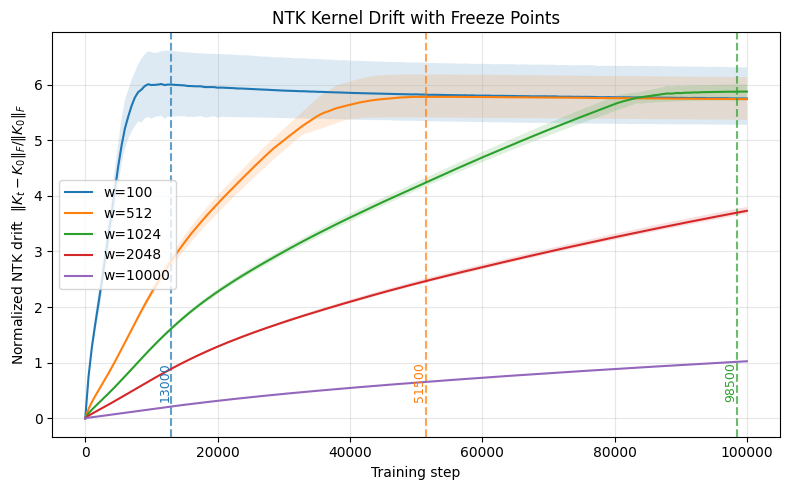

In [ ]:
plot_kernel_drift_for_width(RUN, man, widths_all)

In [6]:
def loss_over_seeds(run_dir, man, width, q_low=10, q_high=90):
    """
    Returns:
        steps_unique  : (T_steps,)
        loss_mean     : (T_steps,)
        loss_lo       : (T_steps,)
        loss_hi       : (T_steps,)
    """

    block = npz(run_dir, man["runs"][str(width)])
    loss_meta   = block["loss_meta"]        # (T_snap, 2) = (seed, step)
    loss_values = block["loss_values"]      # (T_snap,)

    steps_unique = np.sort(np.unique(loss_meta[:, 1]))

    loss_mean = []
    loss_lo   = []
    loss_hi   = []

    for step in steps_unique:
        mask  = (loss_meta[:, 1] == step)
        vals  = loss_values[mask]     # losses across seeds at this step

        mu = vals.mean()
        lo, hi = np.percentile(vals, [q_low, q_high])

        loss_mean.append(mu)
        loss_lo.append(lo)
        loss_hi.append(hi)

    return (
        np.array(steps_unique),
        np.array(loss_mean),
        np.array(loss_lo),
        np.array(loss_hi),
    )

def plot_loss_for_widths(run_dir, man, widths,
                         q_low=10, q_high=90,
                         ymin=None, ymax=None,
                         freeze_dict=None, save_path=None):
    """
    Plot mean loss ± percentile spread across seeds for each width.
    Optionally mark freeze points using a dict {width: freeze_step}.
    """

    plt.figure(figsize=(8,5))

    for width in widths:
        # --- compute mean and spread
        steps, loss_mean, loss_lo, loss_hi = loss_over_seeds(
            run_dir, man, width, q_low=q_low, q_high=q_high
        )

        # --- plot loss curve
        line = plt.plot(steps, loss_mean,color=width_colors[width], label=f"w={width}")[0]
        color = line.get_color()
        plt.fill_between(steps, loss_lo, loss_hi, alpha=0.15, color=color)

        # --- freeze step marker
        if freeze_dict is not None and width in freeze_dict:
            freeze_step = freeze_dict[width]

            if freeze_step is not None:
                plt.axvline(freeze_step, color=color, linestyle="--", alpha=0.8)
                plt.text(
                    freeze_step,
                    loss_mean.max() * 0.8,
                    f"{freeze_step}",
                    rotation=90,
                    va="center",
                    ha="right",
                    fontsize=9,
                    color=color
                )

    # --- axes + formatting
    plt.xlabel("Training step")
    plt.ylabel("Training MSE loss")
    plt.title("Training Loss vs Steps (mean ± spread across seeds)")
    plt.grid(alpha=0.3)
    plt.legend()

    if ymin is not None or ymax is not None:
        plt.ylim(ymin, ymax)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


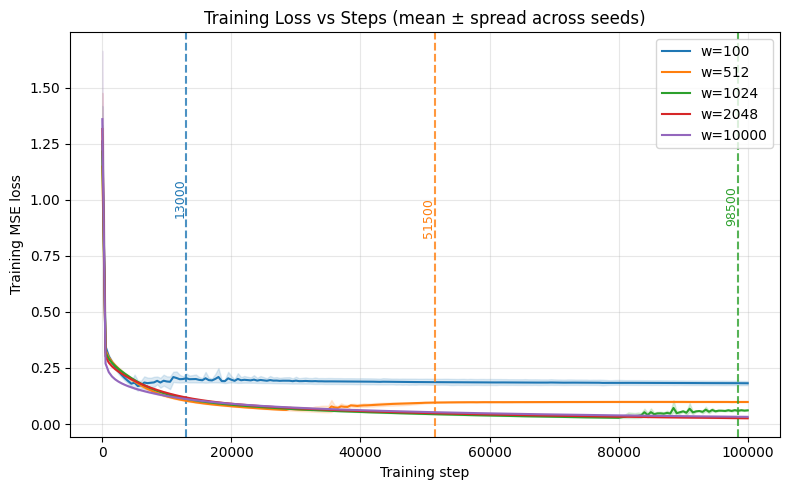

In [10]:
plot_loss_for_widths(RUN, man, widths_all, freeze_dict=freeze_steps)

In [7]:
def eigenvalues_over_time(run_dir, man, width, k=5,
                          q_low=10, q_high=90):
    """
    Compute top-k eigenvalues over time from kernel matrices.

    Returns:
        steps_unique  : (T_steps,)
        eig_mean      : (T_steps, k)
        eig_lo        : (T_steps, k)
        eig_hi        : (T_steps, k)
    """
    block = npz(run_dir, man["runs"][str(width)])
    K_all = block["K_train_train"]     # (T_snap, M, M)
    meta  = block["kernel_meta"]       # (T_snap, 2) = (seed, step)

    steps_unique = np.sort(np.unique(meta[:,1]))

    eig_mean = []
    eig_lo   = []
    eig_hi   = []

    for step in steps_unique:
        mask = (meta[:,1] == step)
        Ks = K_all[mask]   # (n_seeds, M, M)

        eigs_seed = []
        for K in Ks:
            # symmetric eigenvalues
            e = np.linalg.eigvalsh(K.squeeze())
            e_sorted = np.sort(e)[::-1]   # descending
            eigs_seed.append(e_sorted[:k])

        eigs_seed = np.array(eigs_seed)   # (n_seeds, k)

        mu = eigs_seed.mean(axis=0)
        lo, hi = np.percentile(eigs_seed, [q_low, q_high], axis=0)

        eig_mean.append(mu)
        eig_lo.append(lo)
        eig_hi.append(hi)

    return (
        np.array(steps_unique),
        np.array(eig_mean),
        np.array(eig_lo),
        np.array(eig_hi)
    )

def plot_topk_eigenvalues_for_width(run_dir, man, width,
                                    k=5, q_low=10, q_high=90, save_path=None):
    steps, eig_mean, eig_lo, eig_hi = eigenvalues_over_time(
        run_dir, man, width, k=k, q_low=q_low, q_high=q_high
    )

    plt.figure(figsize=(7,5))

    for i in range(k):
        plt.plot(steps, eig_mean[:,i], label=rf"$\lambda_{i+1}$")
        plt.fill_between(steps, eig_lo[:,i], eig_hi[:,i], alpha=0.2)

    plt.xlabel("Training step")
    plt.ylabel("Eigenvalue of K_train_train(t)")
    plt.title(f"Top-{k} NTK eigenvalues over training - width={width}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


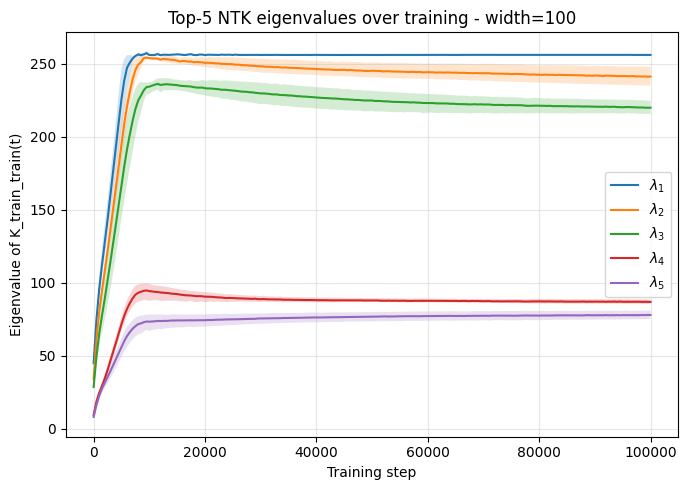

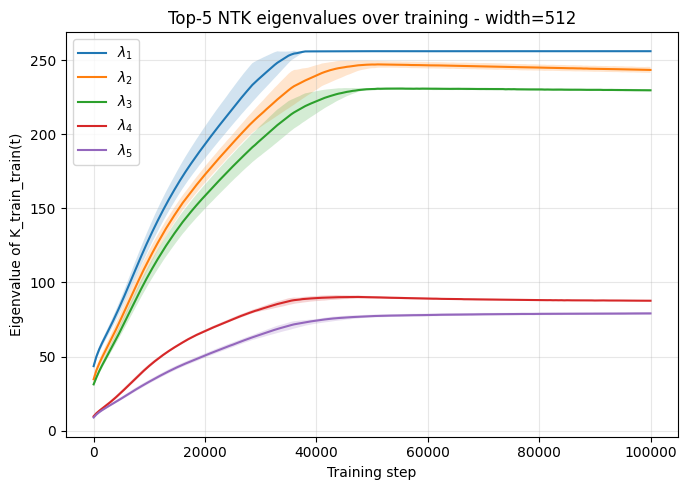

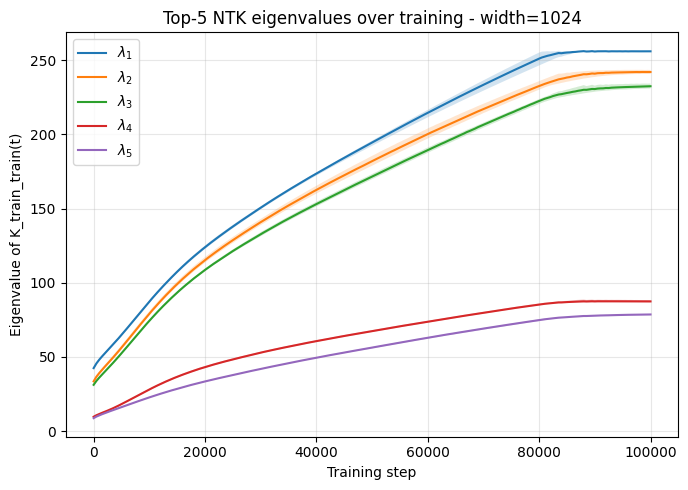

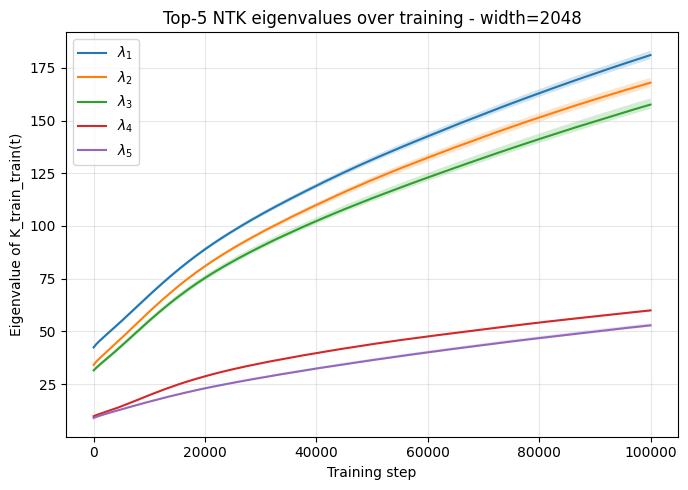

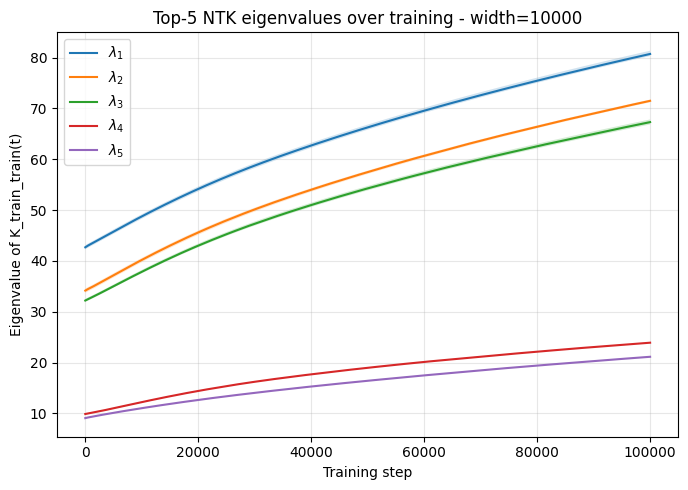

In [98]:
for width in widths_all:
    plot_topk_eigenvalues_for_width(RUN, man, width, k=5)

In [8]:
def get_preds_for_step(block, step):
    """
    Returns:
        seeds: array of seed IDs
        preds_matrix: (n_seeds, n_eval) predictions for that step
                      nearest snapshot if exact step not present.
    """
    meta  = block["preds_meta"]
    preds = block["preds"]

    seeds = np.unique(meta[:,0])
    n_eval = preds.shape[1]

    out = []

    for s in seeds:
        seed_mask  = (meta[:,0] == s)
        seed_steps = meta[seed_mask, 1]
        seed_idxs  = np.where(seed_mask)[0]

        # nearest snapshot if exact missing
        nearest_idx = seed_idxs[np.argmin(np.abs(seed_steps - step))]
        out.append(preds[nearest_idx])

    return seeds, np.array(out)

def plot_predictions_freeze_vs_final_spread(run_dir, man, width, freeze_step,
                                           q_low=10, q_high=90, save_path=None):
    """
    Plot mean prediction ± spread across seeds for:
        - freeze step
        - final step
        - difference between them
    """

    if freeze_step is None:
        print(f"[skip] width={width} has no freeze_step")
        return

    block = npz(run_dir, man["runs"][str(width)])

    # Load eval grid
    data_block = npz(run_dir, man["data_file"])
    gamma_eval = data_block["gamma_eval"]
    y_eval_true = data_block["y_eval_true"]

    # Get all seeds' predictions
    seeds, freeze_preds = get_preds_for_step(block, freeze_step)
    _,      final_preds = get_preds_for_step(block, np.max(block["preds_meta"][:,1]))

    # Compute statistics
    def agg(mat):
        mu = mat.mean(axis=0)
        lo = np.percentile(mat, q_low,  axis=0)
        hi = np.percentile(mat, q_high, axis=0)
        return mu, lo, hi

    mu_fz, lo_fz, hi_fz = agg(freeze_preds)
    mu_fn, lo_fn, hi_fn = agg(final_preds)

    diff_mat = final_preds - freeze_preds
    mu_df, lo_df, hi_df = agg(diff_mat)

    # Plot
    plt.figure(figsize=(10,5))

    plt.plot(gamma_eval, y_eval_true, color="gray", linewidth=2.0,
            label=r"$f^*(\gamma)$", alpha=0.7)

    # freeze predictions
    plt.plot(gamma_eval, mu_fz, label=f"w={width} (t={freeze_step})")
    plt.fill_between(gamma_eval, lo_fz, hi_fz, alpha=0.2)

    # final predictions
    plt.plot(gamma_eval, mu_fn, label=f"w={width} (t={np.max(block['preds_meta'][:,1])})")
    plt.fill_between(gamma_eval, lo_fn, hi_fn, alpha=0.2)

    # difference
    # plt.plot(gamma_eval, mu_df, label="difference", alpha=0.7)
    # plt.fill_between(gamma_eval, lo_df, hi_df, alpha=0.15)

    plt.title(f"Predictions (mean ± spread): width={width}")
    plt.xlabel("γ")
    plt.ylabel("Prediction")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_all_freeze_vs_final_spread(run_dir, man, freeze_dict, widths=None, save_path=None):
    for width in widths or freeze_dict.keys():
        freeze_step = freeze_dict.get(width, None)
        if freeze_step is None:
            continue
        print(f"\n=== width={width}, freeze_step={freeze_step} ===")
        if save_path:
            save_path = Path(save_path).with_name(f"predictions_w{width}_freeze.png") 
        plot_predictions_freeze_vs_final_spread(run_dir, man, width, freeze_step, save_path=save_path)



=== width=100, freeze_step=13000 ===


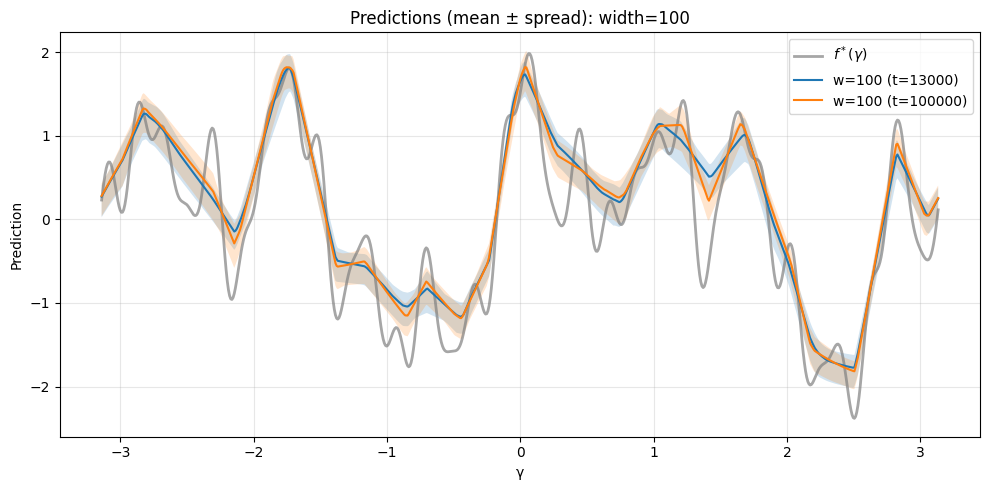


=== width=512, freeze_step=51500 ===


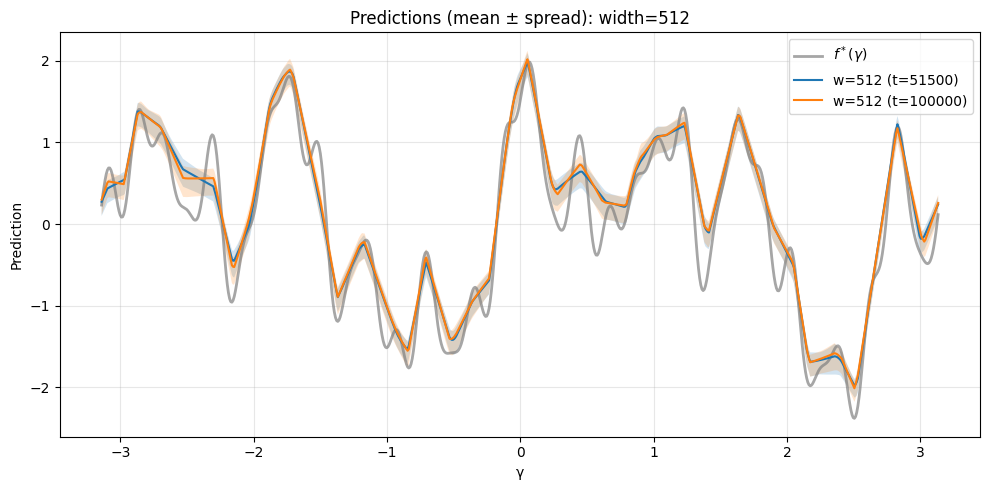


=== width=1024, freeze_step=98500 ===


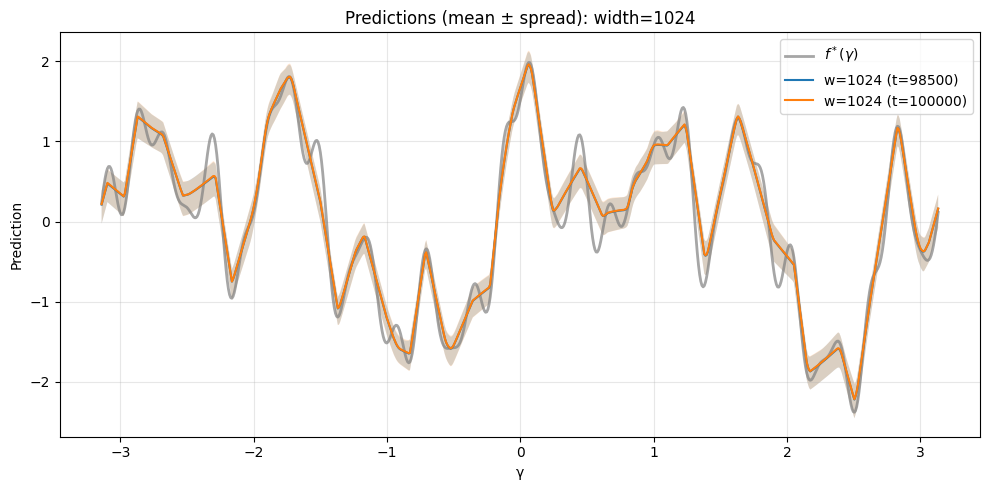

In [12]:
plot_all_freeze_vs_final_spread(RUN, man, freeze_steps)

In [9]:
def get_kernel_matrices_for_step(block, step):
    """
    Returns:
      seeds: array of seeds
      Ks_train: list of (M_train x M_train) matrices, one per seed
      Ks_eval:  list of (n_eval x M_train) matrices, one per seed
    """
    meta = block["kernel_meta"]     # (T_snap, 2) = (seed, step)
    Ktt_all = block["K_train_train"]
    Ket_all = block["K_eval_train"]

    seeds = np.unique(meta[:,0])

    Ks_train = []
    Ks_eval  = []

    for s in seeds:
        mask = (meta[:,0] == s)
        seed_steps = meta[mask,1]
        seed_idxs  = np.where(mask)[0]

        # nearest available snapshot
        nearest = seed_idxs[np.argmin(np.abs(seed_steps - step))]

        Ks_train.append(Ktt_all[nearest].squeeze())
        Ks_eval.append(Ket_all[nearest].squeeze())

    return seeds, Ks_train, Ks_eval


In [10]:
def check_ntk_condition(K_list, seeds):
    conditioning_dict = {}
    for K, s in zip(K_list, seeds):
        conditioning = {}
        K = np.squeeze(K)
        vals = np.linalg.eigvalsh(K)
        lam_min, lam_max = vals.min(), vals.max()
        cond = np.linalg.cond(K)
        asym = np.linalg.norm(K - K.T)

        conditioning["min_eig"] = lam_min
        conditioning["max_eig"] = lam_max
        conditioning["cond"]    = cond
        conditioning["asym"]    = asym

        conditioning_dict[int(s)] = conditioning

    return conditioning_dict


In [74]:
width=100
block = npz(RUN, man["runs"][str(width)])
seeds, Ktts, Kets = get_kernel_matrices_for_step(block, freeze_steps[width])
check_ntk_condition(Ktts, seeds)

{0: {'min_eig': np.float32(-5.97943e-06),
  'max_eig': np.float32(255.94081),
  'cond': np.float32(4.1711937e+11),
  'asym': np.float32(0.0)},
 1: {'min_eig': np.float32(-6.423942e-06),
  'max_eig': np.float32(256.0095),
  'cond': np.float32(2.2242218e+10),
  'asym': np.float32(0.0)},
 2: {'min_eig': np.float32(-6.6477346e-06),
  'max_eig': np.float32(256.35587),
  'cond': np.float32(7.433761e+09),
  'asym': np.float32(0.0)},
 3: {'min_eig': np.float32(-5.61477e-06),
  'max_eig': np.float32(256.00134),
  'cond': np.float32(1.9470707e+10),
  'asym': np.float32(0.0)},
 4: {'min_eig': np.float32(-5.7518137e-06),
  'max_eig': np.float32(256.10016),
  'cond': np.float32(4.5775192e+10),
  'asym': np.float32(0.0)}}

In [75]:
conds = {}
for width in widths_all:
    block = npz(RUN, man["runs"][str(width)])
    if freeze_steps[width] is not None:
        seeds, Ktts, Kets = get_kernel_matrices_for_step(block, freeze_steps[width])
        conds[width] = check_ntk_condition(Ktts, seeds) 

conds

{100: {0: {'min_eig': np.float32(-5.97943e-06),
   'max_eig': np.float32(255.94081),
   'cond': np.float32(4.1711937e+11),
   'asym': np.float32(0.0)},
  1: {'min_eig': np.float32(-6.423942e-06),
   'max_eig': np.float32(256.0095),
   'cond': np.float32(2.2242218e+10),
   'asym': np.float32(0.0)},
  2: {'min_eig': np.float32(-6.6477346e-06),
   'max_eig': np.float32(256.35587),
   'cond': np.float32(7.433761e+09),
   'asym': np.float32(0.0)},
  3: {'min_eig': np.float32(-5.61477e-06),
   'max_eig': np.float32(256.00134),
   'cond': np.float32(1.9470707e+10),
   'asym': np.float32(0.0)},
  4: {'min_eig': np.float32(-5.7518137e-06),
   'max_eig': np.float32(256.10016),
   'cond': np.float32(4.5775192e+10),
   'asym': np.float32(0.0)}},
 512: {0: {'min_eig': np.float32(-3.038144e-06),
   'max_eig': np.float32(255.94235),
   'cond': np.float32(1.5624585e+10),
   'asym': np.float32(0.0)},
  1: {'min_eig': np.float32(-2.7917629e-06),
   'max_eig': np.float32(256.01642),
   'cond': np.float32

In [49]:
width=10000
block = npz(RUN, man["runs"][str(width)])
seeds, Ktts, Kets = get_kernel_matrices_for_step(block, 100000)
check_ntk_condition(Ktts, seeds)


Seed 0:
  min eig: -5.834795e-07
  max eig: 80.3872
  cond(K): 3.6446602e+09
  asym(K): 0.0

Seed 1:
  min eig: -5.678847e-07
  max eig: 81.73397
  cond(K): 5.1525064e+09
  asym(K): 0.0

Seed 2:
  min eig: -7.032007e-07
  max eig: 80.22454
  cond(K): 5.580581e+09
  asym(K): 0.0

Seed 3:
  min eig: -8.353347e-07
  max eig: 80.41831
  cond(K): 7.105481e+09
  asym(K): 0.0

Seed 4:
  min eig: -7.9732604e-07
  max eig: 80.74561
  cond(K): 7.771028e+09
  asym(K): 0.0


In [11]:
def kernel_regression(K_train, K_eval, y_train, reg=1e-6):
    M = K_train.shape[0]
    A = K_train + reg * np.eye(M)
    alpha = np.linalg.solve(A, y_train)
    return K_eval @ alpha

def aggregate_kernel_predictions(Ks_train, Ks_eval, y_train, reg=1e-6,
                                 q_low=10, q_high=90):
    preds = []

    for Ktt, Ket in zip(Ks_train, Ks_eval):
        f_kr = kernel_regression(Ktt, Ket, y_train, reg=reg)
        preds.append(f_kr)

    preds = np.array(preds)   # (n_seeds, n_eval)

    mu = preds.mean(axis=0)
    lo = np.percentile(preds, q_low,  axis=0)
    hi = np.percentile(preds, q_high, axis=0)

    return mu, lo, hi, preds

def plot_kernel_regression_for_width(run_dir, man, width, kr_step,
                                     q_low=10, q_high=90,
                                     reg=1e-6,
                                     plot_network_final=True, save_path=None):

    block = npz(run_dir, man["runs"][str(width)])
    data_block = npz(run_dir, man["data_file"])

    gamma_eval  = data_block["gamma_eval"]
    y_eval_true = data_block["y_eval_true"]
    y_train     = block["y_train"]

    # --- extract NTK matrices for each seed at step kr_step
    seeds, Ks_train, Ks_eval = get_kernel_matrices_for_step(block, kr_step)

    # --- kernel regression
    mu, lo, hi, all_preds = aggregate_kernel_predictions(
        Ks_train, Ks_eval, y_train, reg=reg,
        q_low=q_low, q_high=q_high
    )

    # --- plot
    plt.figure(figsize=(10,5))

    # target
    plt.plot(gamma_eval, y_eval_true, color="gray",
             linewidth=2.0, label=r"$f^*(\gamma)$", alpha=0.9)

    # kernel regression mean
    plt.plot(gamma_eval, mu,
             label=fr"$f_{{KR}}(t={kr_step})$(regularized $\lambda$={reg})",)
    plt.fill_between(gamma_eval, lo, hi, alpha=0.2)

    # network final prediction (optional)
    if plot_network_final:
        final_step = int(np.max(block["preds_meta"][:,1]))
        _, final_preds = get_preds_for_step(block, final_step)
        mu_fn = final_preds.mean(axis=0)
        lo_fn = np.percentile(final_preds, q_low,  axis=0)
        hi_fn = np.percentile(final_preds, q_high, axis=0)
        plt.plot(gamma_eval, mu_fn,
                 label=fr"$f_{{{width}}}(t={final_step})$",
                 linestyle="--")
        plt.fill_between(gamma_eval, lo_fn, hi_fn, alpha=0.1)

    plt.title(f"Kernel Regression at t={kr_step} (width={width})")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Prediction")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_kernel_regression_all(run_dir, man, kr_dict,
                               reg=1e-6, q_low=10, q_high=90, save_path=None):
    for width, kr_step in kr_dict.items():
        if kr_step is None:
            print(f"Skipping width {width}: no kr_step")
            continue
        print(f"\n=== width={width}, KR step={kr_step} ===")
        if save_path:
            save_path = Path(save_path).with_name(f"kernel_regression_w{width}_step.png")
        plot_kernel_regression_for_width(
            run_dir, man, width, kr_step,
            reg=reg, q_low=q_low, q_high=q_high, save_path=save_path
        )


=== width=100, KR step=13000 ===


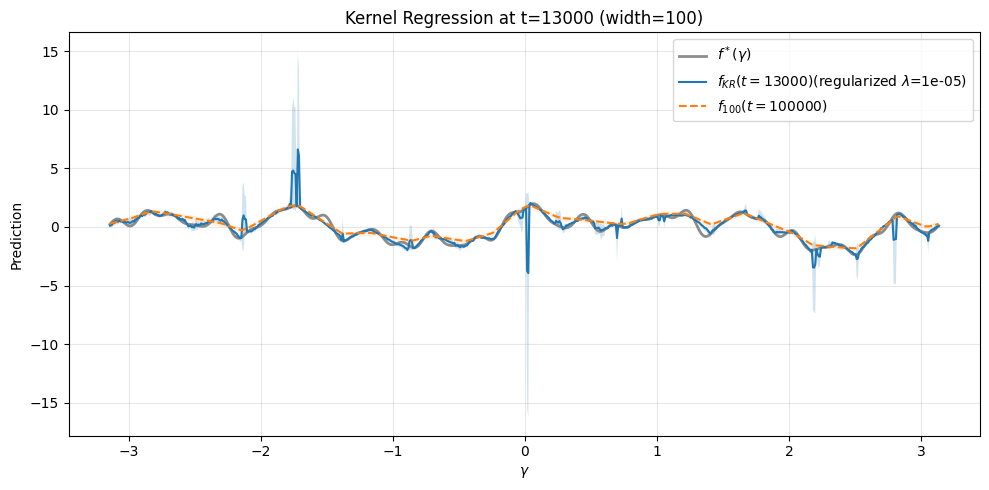


=== width=512, KR step=51500 ===


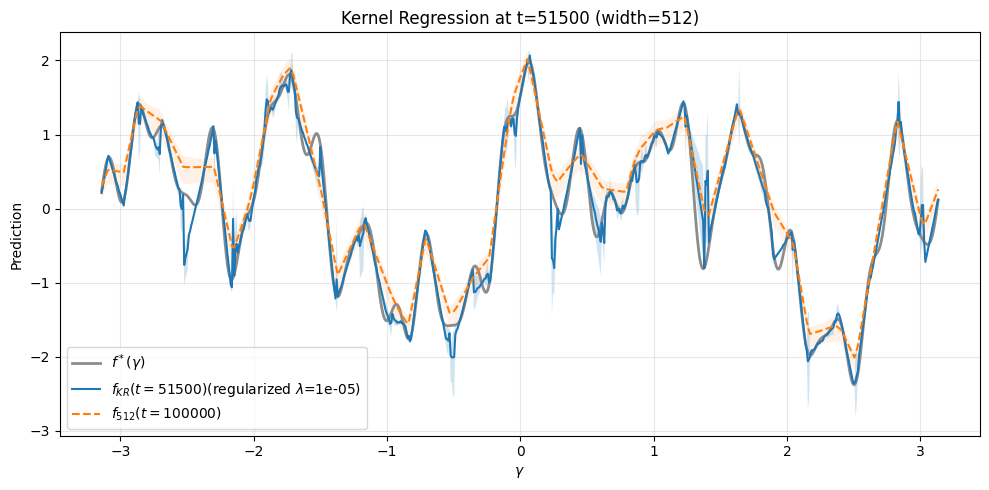


=== width=1024, KR step=98500 ===


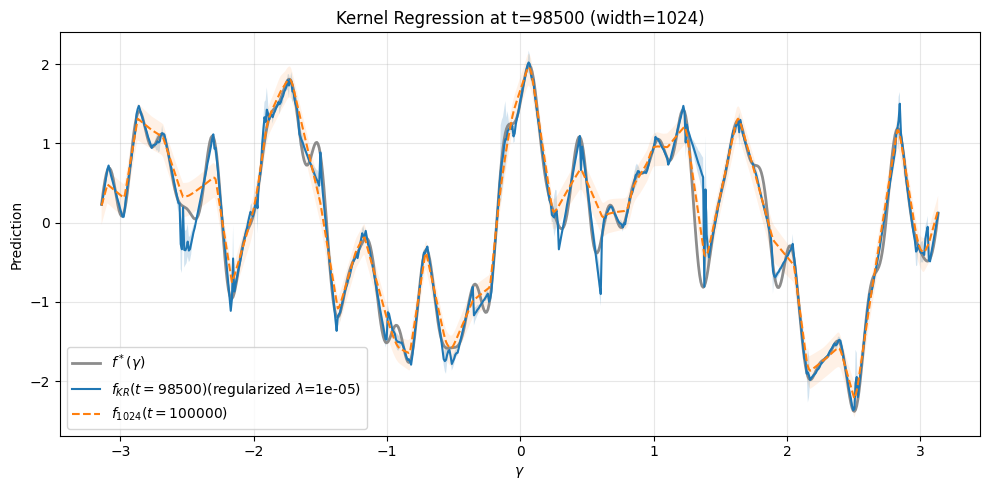

Skipping width 2048: no kr_step
Skipping width 10000: no kr_step


In [40]:
plot_kernel_regression_all(RUN, man, freeze_steps, reg=1e-5)

In [12]:
def plot_error_vs_width(run_dir, man, freeze_dict, reg=1e-3,
                        q_low=10, q_high=90, save_path=None):
    """
    Plot:
        mean L2 error vs width
        ± percentile spread across seeds
    For:
        - Kernel Regression at freeze step
        - Final Network predictions
    """
    data_block = npz(run_dir, man["data_file"])
    y_eval_true = data_block["y_eval_true"]

    widths = []
    kr_means = []
    kr_los = []
    kr_his = []
    nn_means = []
    nn_los = []
    nn_his = []

    for width, freeze_step in freeze_dict.items():
        if freeze_step is None:
            continue

        block = npz(run_dir, man["runs"][str(width)])
        y_train = block["y_train"]

        # KR predictions
        seeds, Ktts, Kets = get_kernel_matrices_for_step(block, freeze_step)
        kr_preds = []
        for Ktt, Ket in zip(Ktts, Kets):
            pred = kernel_regression(Ktt, Ket, y_train, reg=reg)
            kr_preds.append(pred)
        kr_preds = np.array(kr_preds)  # (n_seeds, n_eval)

        # Final NN predictions
        final_step = int(np.max(block["preds_meta"][:,1]))
        _, final_preds = get_preds_for_step(block, final_step)
        final_preds = np.array(final_preds)

        # Errors
        err_kr = np.linalg.norm(kr_preds - y_eval_true, axis=1)
        err_nn = np.linalg.norm(final_preds - y_eval_true, axis=1)

        # Aggregate
        widths.append(width)

        kr_means.append(err_kr.mean())
        kr_los.append(np.percentile(err_kr, q_low))
        kr_his.append(np.percentile(err_kr, q_high))

        nn_means.append(err_nn.mean())
        nn_los.append(np.percentile(err_nn, q_low))
        nn_his.append(np.percentile(err_nn, q_high))

    widths = np.array(widths)

    # ---- Plot ----
    plt.figure(figsize=(7,5))

    # KR curve + spread
    plt.plot(widths, kr_means, "o-", label="Kernel Regression")
    plt.fill_between(widths, kr_los, kr_his, alpha=0.25)

    # NN curve + spread
    plt.plot(widths, nn_means, "o-", label="Final Network")
    plt.fill_between(widths, nn_los, nn_his, alpha=0.25)

    plt.xscale("log")
    plt.xlabel("Width")
    plt.ylabel(r"$\|f(\gamma) - f^*(\gamma)\|_2$")
    plt.title("Error vs Width (mean ± spread across seeds)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


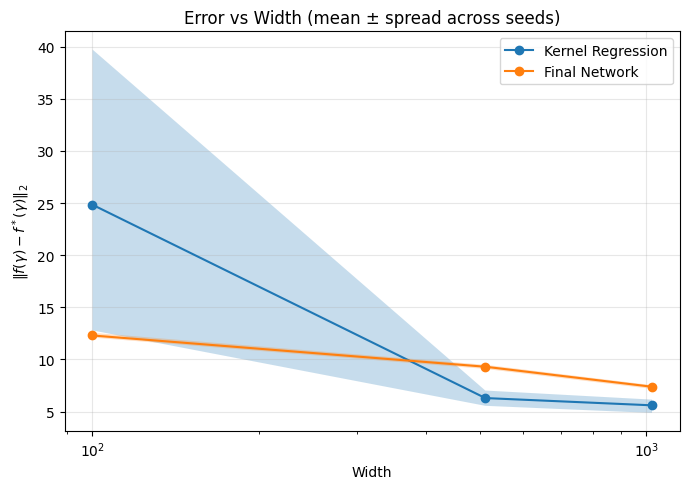

In [47]:
plot_error_vs_width(RUN, man, freeze_steps, reg=1e-5)



## Training longer for higher widths

In [50]:
BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN = latest_run_dir(BASE, EXP)

man = load_manifest(RUN)
man

{'data_file': 'data_fourier.npz',
 'runs': {'1024': 'runs/width_1024.npz',
  '2048': 'runs/width_2048.npz',
  '10000': 'runs/width_10000.npz'},
 'meta': {'widths': [1024, 2048, 10000],
  'seeds': 5,
  'steps': 1000000,
  'lr': 1.0,
  'eval_every': 5000,
  'depth_hidden': 1,
  'M_train': 256,
  'n_eval': 720,
  'noise_std': 0.02},
 'runtime_sec': 10149.67}

In [51]:
widths_all = man["meta"]["widths"]
freeze_steps = {}
for width in widths_all:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN, man, width, normalize=True)
    freeze_step = find_freeze_step(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step

print(freeze_steps)

Width 1024 freeze step: 115000
Width 2048 freeze step: 310000
Width 10000 freeze step: None
{1024: 115000, 2048: 310000, 10000: None}


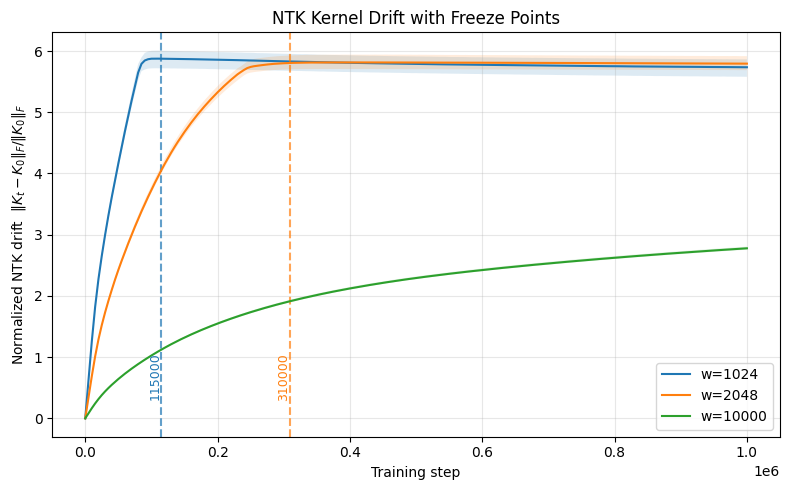

In [52]:
plot_kernel_drift_for_width(RUN, man, widths_all)

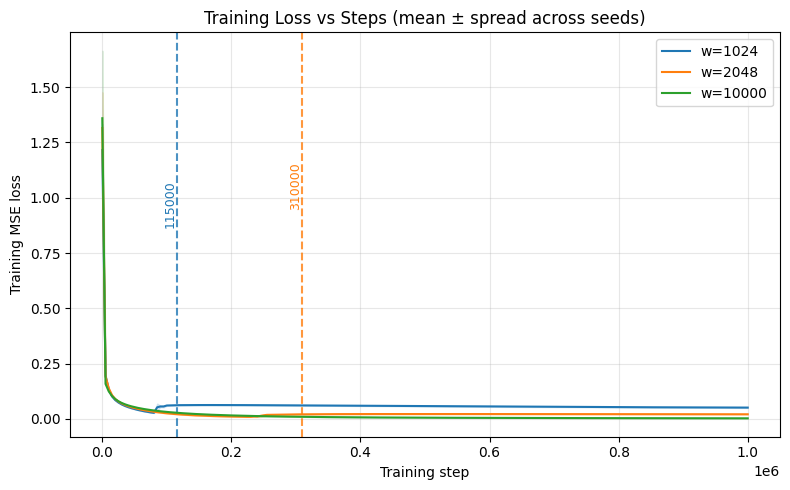

In [53]:
plot_loss_for_widths(RUN, man, widths_all, freeze_dict=freeze_steps)


=== width=1024, freeze_step=115000 ===


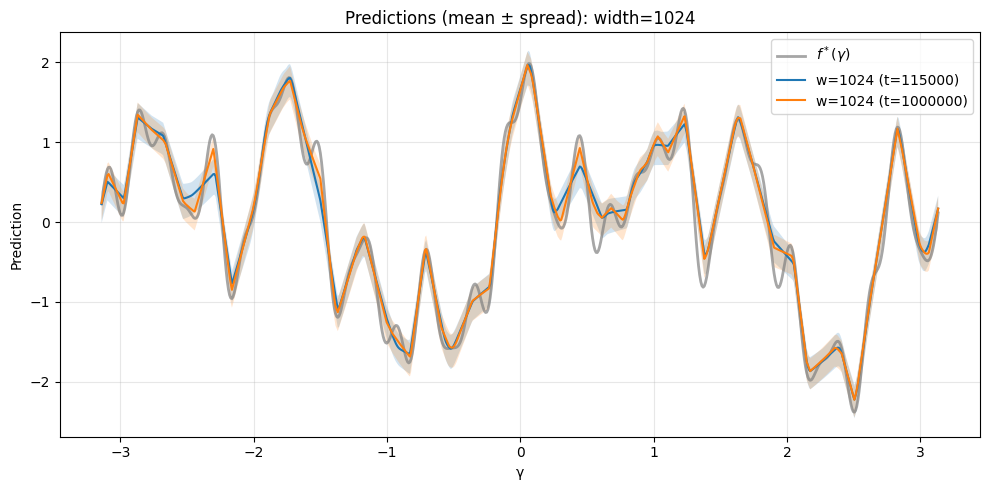


=== width=2048, freeze_step=310000 ===


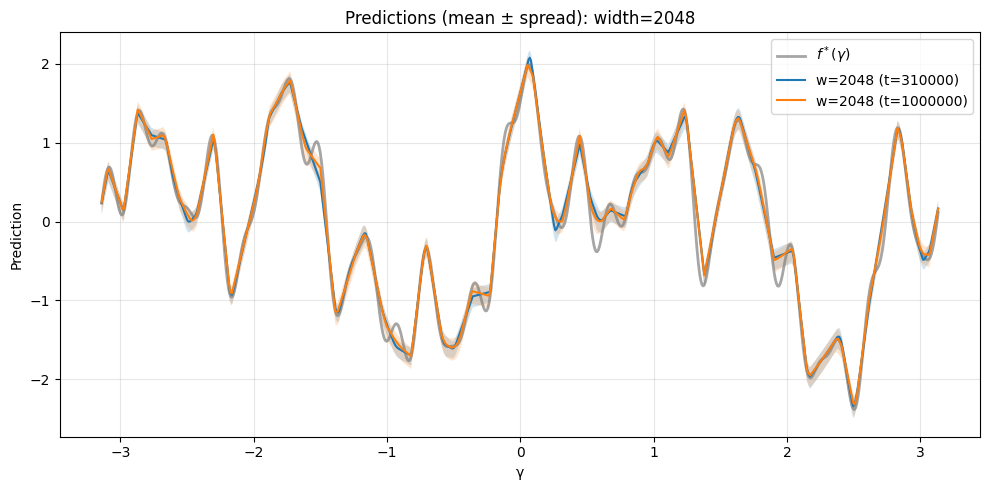

In [54]:
plot_all_freeze_vs_final_spread(RUN, man, freeze_steps)


=== width=1024, KR step=115000 ===


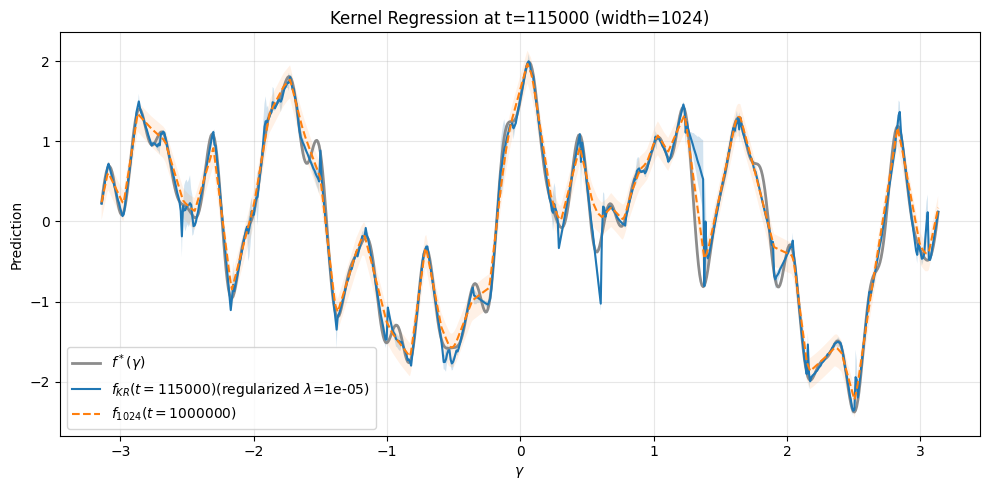


=== width=2048, KR step=310000 ===


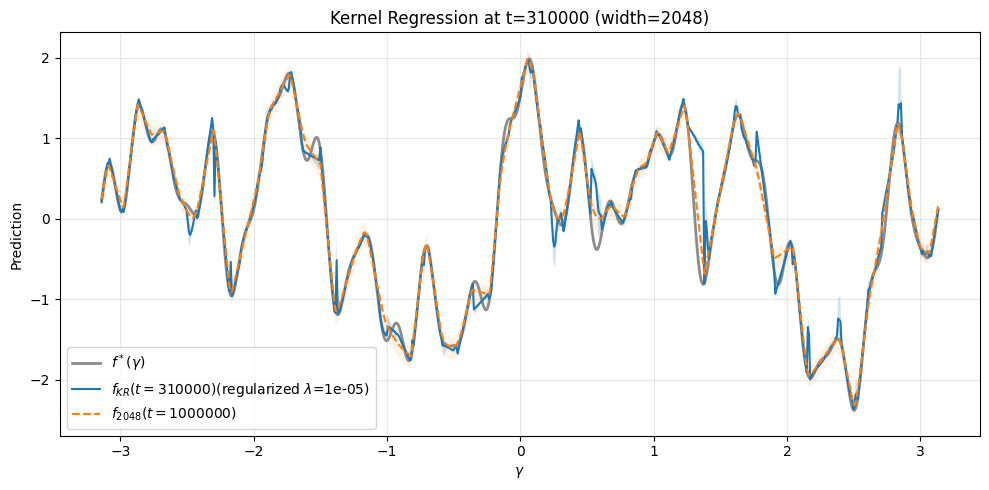

Skipping width 10000: no kr_step


In [57]:
plot_kernel_regression_all(RUN, man, freeze_steps, reg=1e-5)

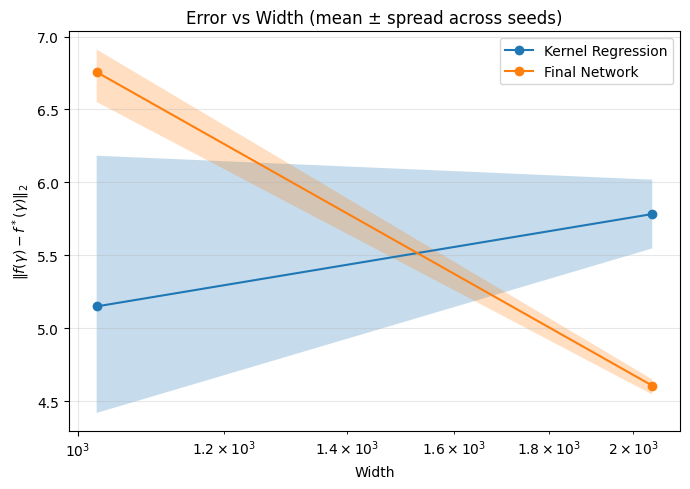

In [58]:
plot_error_vs_width(RUN, man, freeze_steps, reg=1e-5)

In [13]:
def collect_error_vs_width(run_dir, man, freeze_dict, 
                           widths_subset, reg=1e-3, 
                           q_low=10, q_high=90):
    """
    Collect mean + percentile error for:
        - f_KR(t_freeze)
        - f_net(t_freeze)
        - f_net(t_final)
    """

    data_block = npz(run_dir, man["data_file"])
    y_eval_true = data_block["y_eval_true"]

    widths = []

    kr_mean = [];      kr_lo = [];      kr_hi = []
    nnf_mean = [];     nnf_lo = [];     nnf_hi = []     # f_net(freeze)
    nnfinal_mean = []; nnfinal_lo = []; nnfinal_hi = [] # f_net(final)

    for width in widths_subset:

        freeze_step = freeze_dict.get(width, None)
        if freeze_step is None:
            continue

        block = npz(run_dir, man["runs"][str(width)])
        y_train = block["y_train"]

        # -------------------------
        # f_KR(t_freeze)
        # -------------------------
        seeds, Ktts, Kets = get_kernel_matrices_for_step(block, freeze_step)
        kr_preds = np.array([
            kernel_regression(Ktt, Ket, y_train, reg)
            for Ktt, Ket in zip(Ktts, Kets)
        ])

        # -------------------------
        # f_net(t_freeze)
        # -------------------------
        _, net_freeze_preds = get_preds_for_step(block, freeze_step)
        net_freeze_preds = np.array(net_freeze_preds)

        # -------------------------
        # f_net(t_final)
        # -------------------------
        final_step = int(np.max(block["preds_meta"][:,1]))
        _, net_final_preds = get_preds_for_step(block, final_step)
        net_final_preds = np.array(net_final_preds)

        # -------------------------
        # Errors (L2 across eval points)
        # -------------------------
        err_kr        = np.linalg.norm(kr_preds - y_eval_true, axis=1)
        err_net_freeze = np.linalg.norm(net_freeze_preds - y_eval_true, axis=1)
        err_net_final  = np.linalg.norm(net_final_preds - y_eval_true, axis=1)

        widths.append(width)

        # aggregate with percentiles
        kr_mean.append(err_kr.mean())
        kr_lo.append(np.percentile(err_kr, q_low))
        kr_hi.append(np.percentile(err_kr, q_high))

        nnf_mean.append(err_net_freeze.mean())
        nnf_lo.append(np.percentile(err_net_freeze, q_low))
        nnf_hi.append(np.percentile(err_net_freeze, q_high))

        nnfinal_mean.append(err_net_final.mean())
        nnfinal_lo.append(np.percentile(err_net_final, q_low))
        nnfinal_hi.append(np.percentile(err_net_final, q_high))

    return {
        "widths": np.array(widths),
        "kr_mean": np.array(kr_mean),
        "kr_lo":   np.array(kr_lo),
        "kr_hi":   np.array(kr_hi),
        "nnf_mean": np.array(nnf_mean),
        "nnf_lo":   np.array(nnf_lo),
        "nnf_hi":   np.array(nnf_hi),
        "nnfinal_mean": np.array(nnfinal_mean),
        "nnfinal_lo":   np.array(nnfinal_lo),
        "nnfinal_hi":   np.array(nnfinal_hi),
    }


def plot_error_vs_width_multi(run_data_dict, save_path=None, reg=1e-6):
    """
    Plot error vs width using:
        - f_KR(t_freeze)
        - f_net(t_freeze)
        - f_net(t_final)
    from multiple runs.
    """

    all_widths = []
    kr_mean = []; kr_lo = []; kr_hi = []
    nnf_mean = []; nnf_lo = []; nnf_hi = []
    nnfinal_mean = []; nnfinal_lo = []; nnfinal_hi = []

    # -------------------------
    #  Collect from all runs
    # -------------------------
    for _, (run_dir, man, freeze_dict, widths_subset) in run_data_dict.items():

        data = collect_error_vs_width(run_dir, man, freeze_dict, widths_subset, reg=reg)

        all_widths.extend(data["widths"])
        kr_mean.extend(data["kr_mean"])
        kr_lo.extend(data["kr_lo"])
        kr_hi.extend(data["kr_hi"])

        nnf_mean.extend(data["nnf_mean"])
        nnf_lo.extend(data["nnf_lo"])
        nnf_hi.extend(data["nnf_hi"])

        nnfinal_mean.extend(data["nnfinal_mean"])
        nnfinal_lo.extend(data["nnfinal_lo"])
        nnfinal_hi.extend(data["nnfinal_hi"])

    # -------------------------
    # Convert + sort
    # -------------------------
    widths = np.array(all_widths)
    idx = np.argsort(widths)
    widths = widths[idx]

    kr_mean = np.array(kr_mean)[idx]
    kr_lo   = np.array(kr_lo)[idx]
    kr_hi   = np.array(kr_hi)[idx]

    nnf_mean = np.array(nnf_mean)[idx]
    nnf_lo   = np.array(nnf_lo)[idx]
    nnf_hi   = np.array(nnf_hi)[idx]

    nnfinal_mean = np.array(nnfinal_mean)[idx]
    nnfinal_lo   = np.array(nnfinal_lo)[idx]
    nnfinal_hi   = np.array(nnfinal_hi)[idx]

    # -------------------------
    # Error bars
    # -------------------------
    kr_err = [kr_mean - kr_lo, kr_hi - kr_mean]
    nnf_err = [nnf_mean - nnf_lo, nnf_hi - nnf_mean]
    nnfinal_err = [nnfinal_mean - nnfinal_lo, nnfinal_hi - nnfinal_mean]

    # -------------------------
    # Plotting
    # -------------------------
    plt.figure(figsize=(8, 5))

    plt.errorbar(widths, kr_mean, yerr=kr_err,
                 fmt="o-", capsize=5,
                 label=r"$f_{\mathrm{KR}}(t_{\text{freeze}})$")

    plt.errorbar(widths, nnf_mean, yerr=nnf_err,
                 fmt="s--", capsize=5,
                 label=r"$f_{\text{net}}(t_{\text{freeze}})$")

    plt.errorbar(widths, nnfinal_mean, yerr=nnfinal_err,
                 fmt="d--", capsize=5,
                 label=r"$f_{\text{net}}(t_{\text{final}})$")

    plt.xticks(widths, [str(w) for w in widths])
    plt.xlabel("Width")
    plt.ylabel(r"$\|f(\gamma) - f^*(\gamma)\|_2$")
    plt.title("Error vs Width for $f_{\mathrm{KR}}$, $f_{\text{net}}(freeze)$, $f_{\text{net}}(final)$")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


In [14]:
BASE = "../results"; EXP = "ntk_kernel_drift"
RUN_1 = latest_run_dir(BASE, EXP)

man_1 = load_manifest(RUN_1)

BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN_2 = latest_run_dir(BASE, EXP)   

man_2 = load_manifest(RUN_2)

BASE = "../results"; EXP = "ntk_kernel_drift_10000_more_steps"
RUN_3 = latest_run_dir(BASE, EXP)

man_3 = load_manifest(RUN_3)

In [24]:
widths_1 = [100, 512]
widths_2 = [1024, 2048, 10000]
widths_3 = [10000]

freeze_steps = {}
for width in widths_1:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN_1, man_1, width, normalize=True)
    freeze_step = find_freeze_step(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step

for width in widths_2:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN_2, man_2, width, normalize=True)
    freeze_step = find_freeze_step(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step

for width in widths_3:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN_3, man_3, width, normalize=True)
    freeze_step = find_freeze_step(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step
print(freeze_steps)



Width 100 freeze step: 13000
Width 512 freeze step: 51500
Width 1024 freeze step: 115000
Width 2048 freeze step: 310000
Width 10000 freeze step: None
Width 10000 freeze step: None
{100: 13000, 512: 51500, 1024: 115000, 2048: 310000, 10000: None}


In [16]:
import os
from pathlib import Path

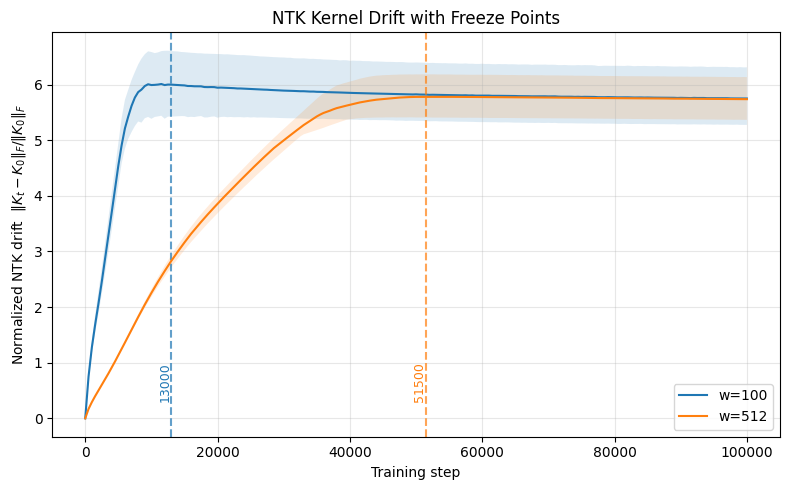

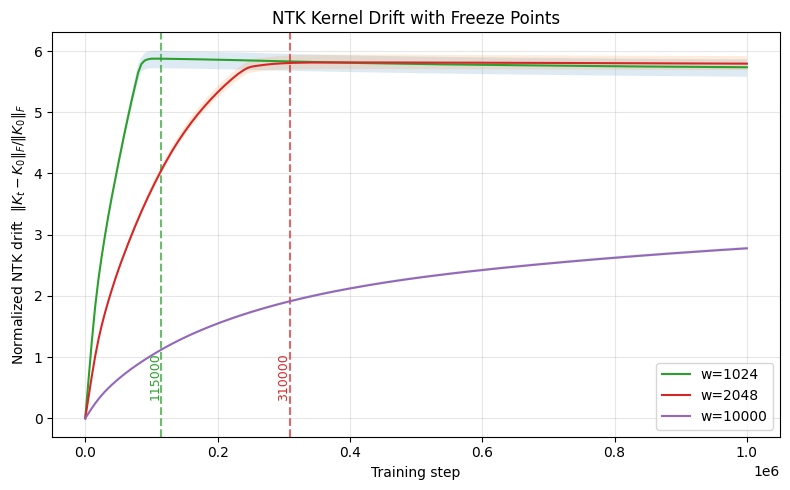

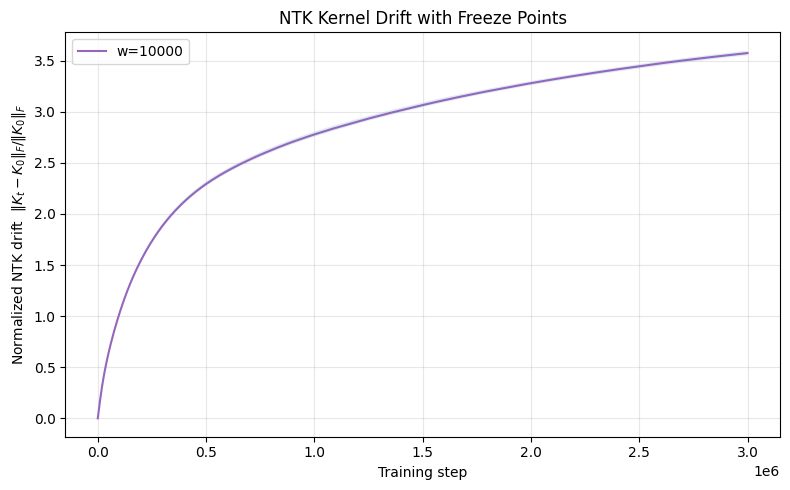

In [17]:
base_path = Path("plots") / "kernel_drift"
os.makedirs(base_path, exist_ok=True)
plot_kernel_drift_for_width(RUN_1, man_1, widths_1, save_path=base_path / "kernel_drift_low_widths.png")
plot_kernel_drift_for_width(RUN_2, man_2, widths_2, save_path=base_path / "kernel_drift_mid_widths.png")
plot_kernel_drift_for_width(RUN_3, man_3, widths_3, save_path=base_path / "kernel_drift_high_widths.png")

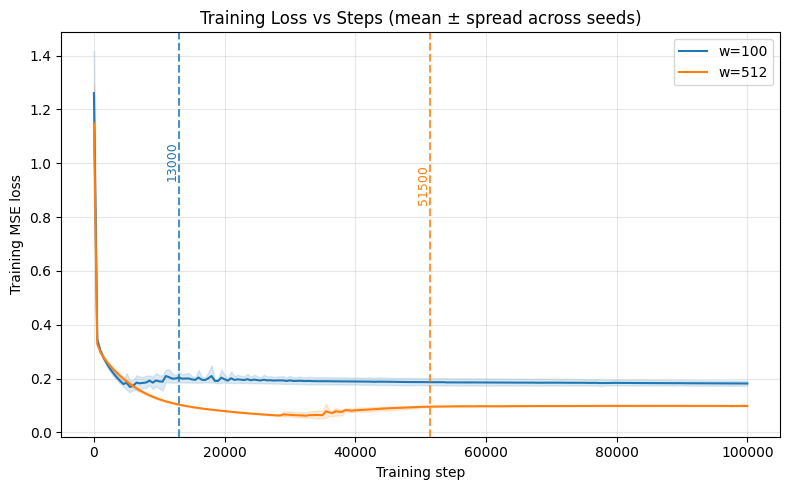

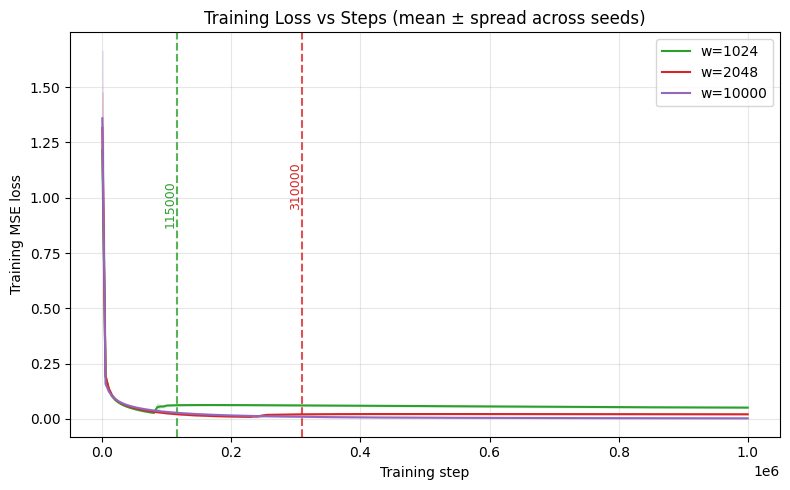

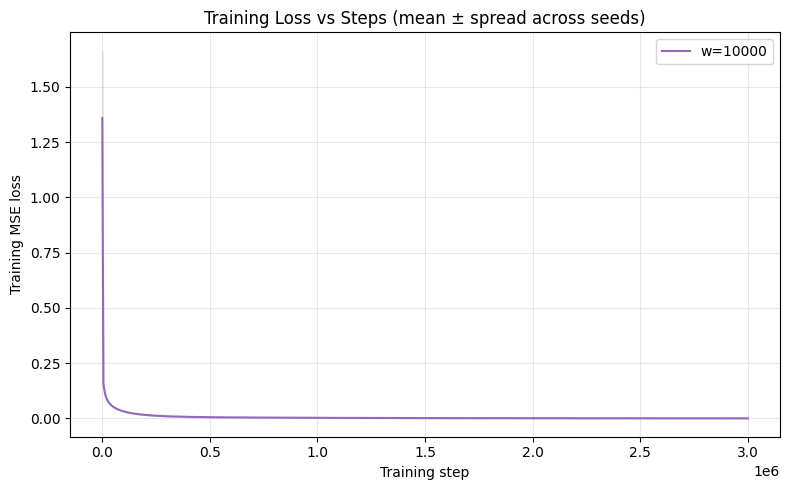

In [18]:
base_path = Path("plots") / "loss_curves"
os.makedirs(base_path, exist_ok=True)

plot_loss_for_widths(RUN_1, man_1, widths_1, freeze_dict=freeze_steps, save_path=base_path / "loss_low_widths.png")
plot_loss_for_widths(RUN_2, man_2, widths_2, freeze_dict=freeze_steps, save_path=base_path / "loss_mid_widths.png")
plot_loss_for_widths(RUN_3, man_3, widths_3, freeze_dict=freeze_steps, save_path=base_path / "loss_high_widths.png")


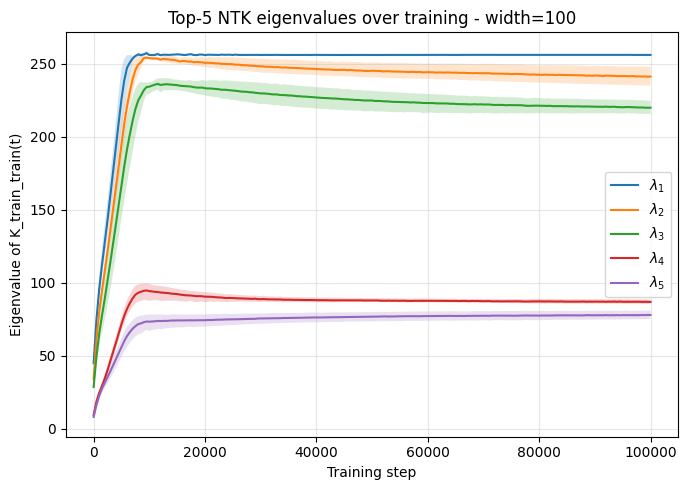

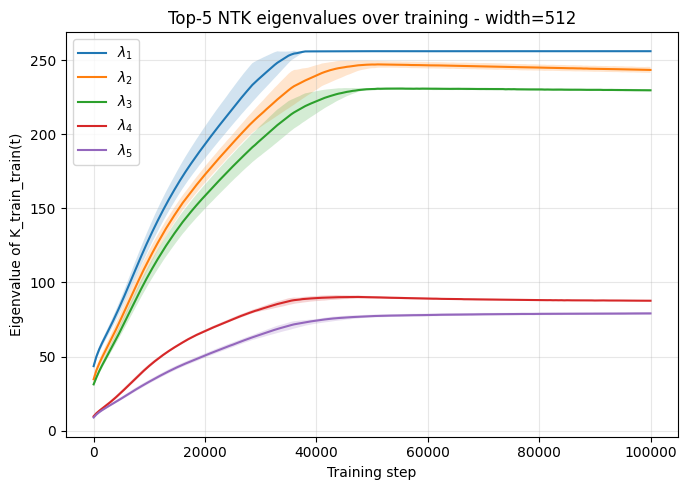

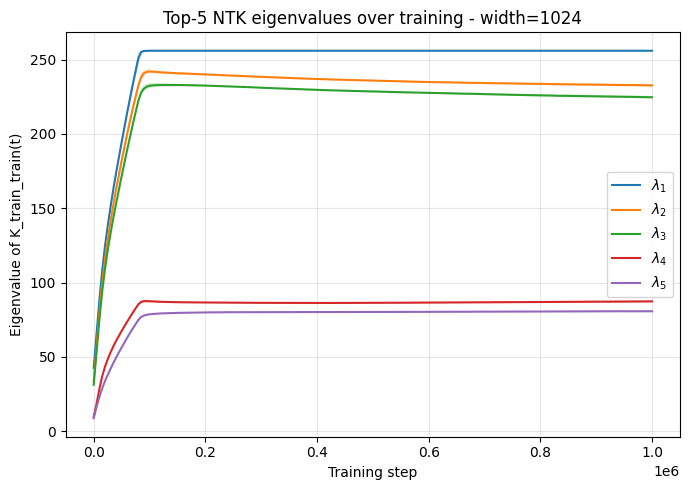

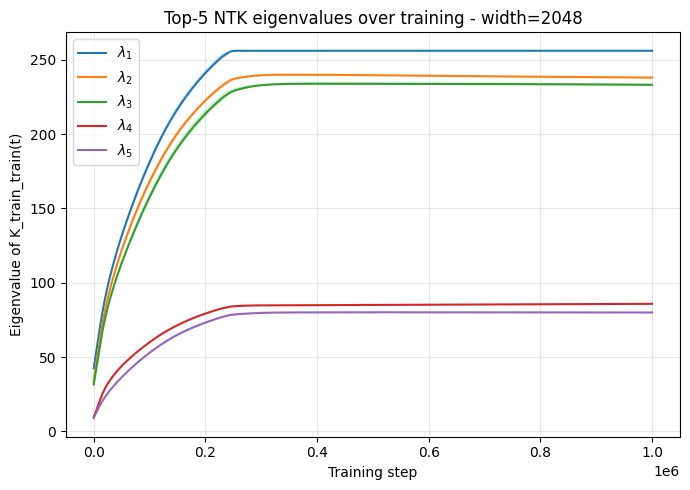

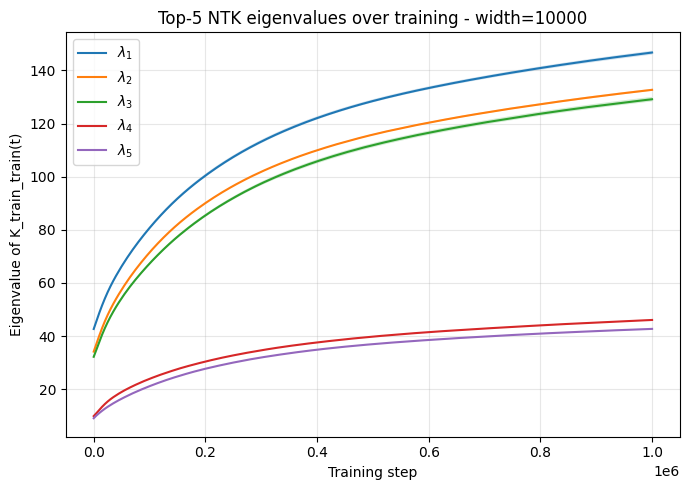

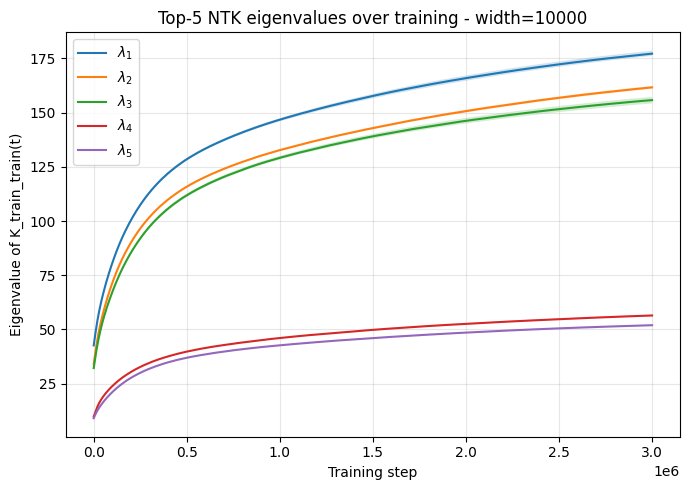

In [19]:
base_path = Path("plots") / "eigenvalues"
os.makedirs(base_path, exist_ok=True)

for width in widths_1:
    plot_topk_eigenvalues_for_width(RUN_1, man_1, width, k=5, save_path=base_path / f"eigenvalues_w{width}.png")

for width in widths_2:
    plot_topk_eigenvalues_for_width(RUN_2, man_2, width, k=5, save_path=base_path / f"eigenvalues_w{width}.png")

for width in widths_3:
    plot_topk_eigenvalues_for_width(RUN_3, man_3, width, k=5, save_path=base_path / f"eigenvalues_w{width}.png")


=== width=100, freeze_step=13000 ===


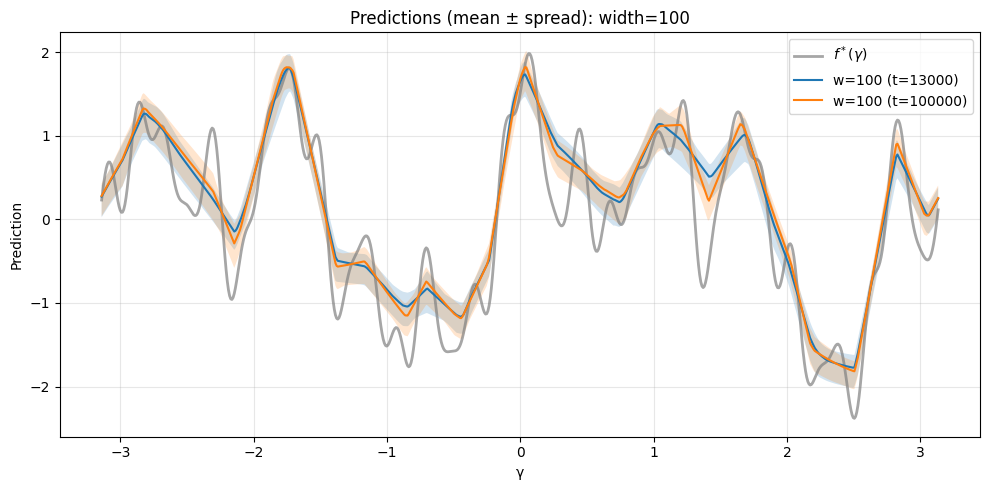


=== width=512, freeze_step=51500 ===


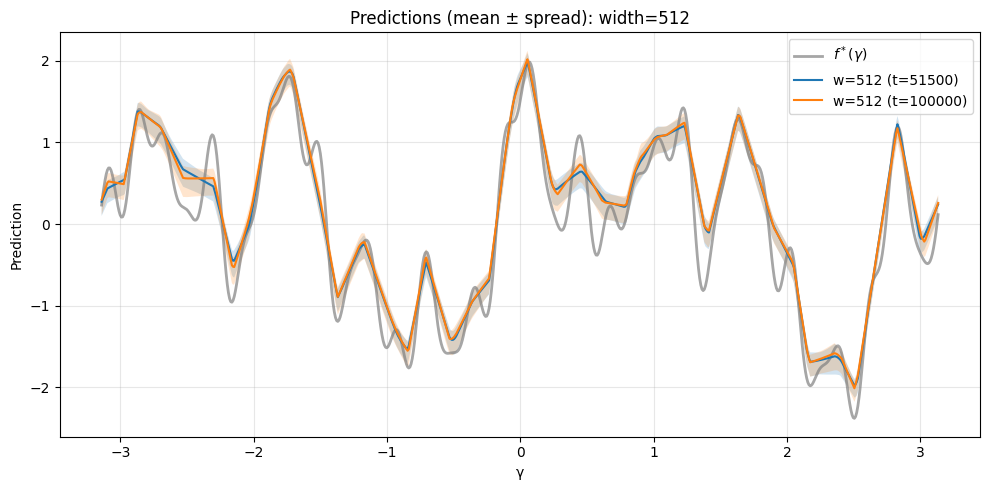


=== width=1024, freeze_step=115000 ===


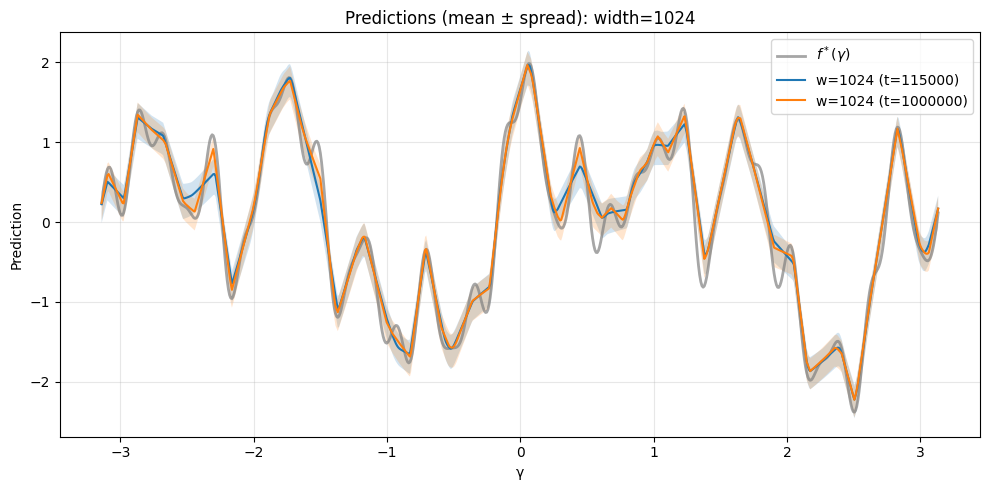


=== width=2048, freeze_step=310000 ===


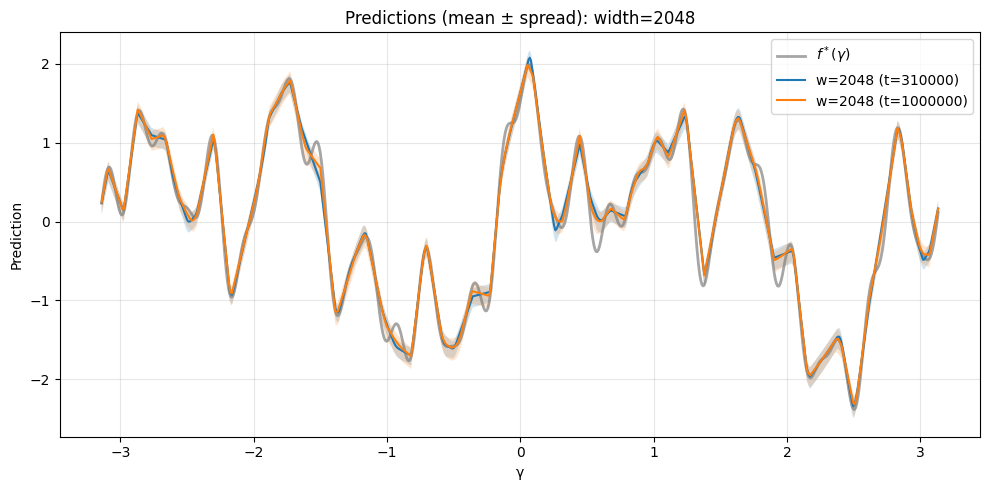

In [20]:
base_path = Path("plots") / "freeze_vs_final_spread"
os.makedirs(base_path, exist_ok=True)

plot_all_freeze_vs_final_spread(RUN_1, man_1, freeze_steps, widths=widths_1, save_path=base_path / "freeze_vs_final_low_widths.png")
plot_all_freeze_vs_final_spread(RUN_2, man_2, freeze_steps, widths=widths_2, save_path=base_path / "freeze_vs_final_mid_widths.png")
plot_all_freeze_vs_final_spread(RUN_3, man_3, freeze_steps, widths=widths_3, save_path=base_path / "freeze_vs_final_high_widths.png")


=== width=100, KR step=13000 ===


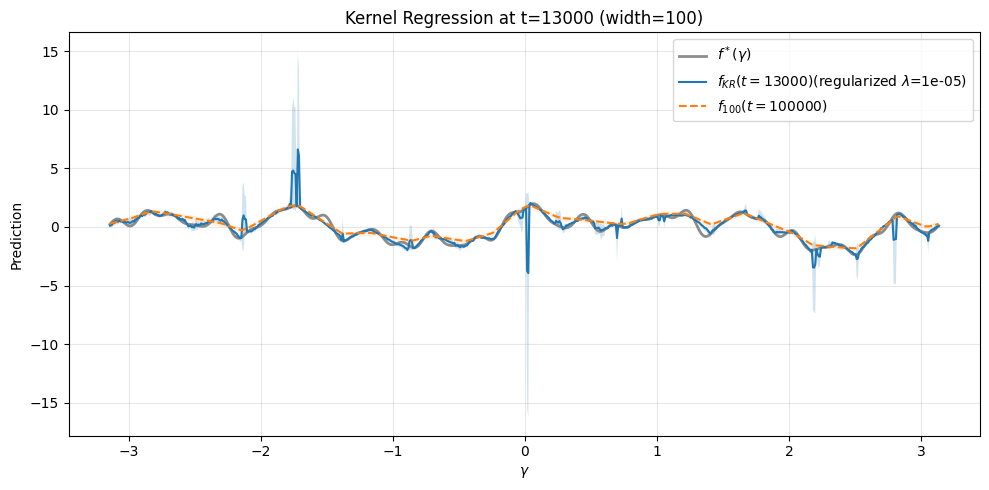


=== width=512, KR step=51500 ===


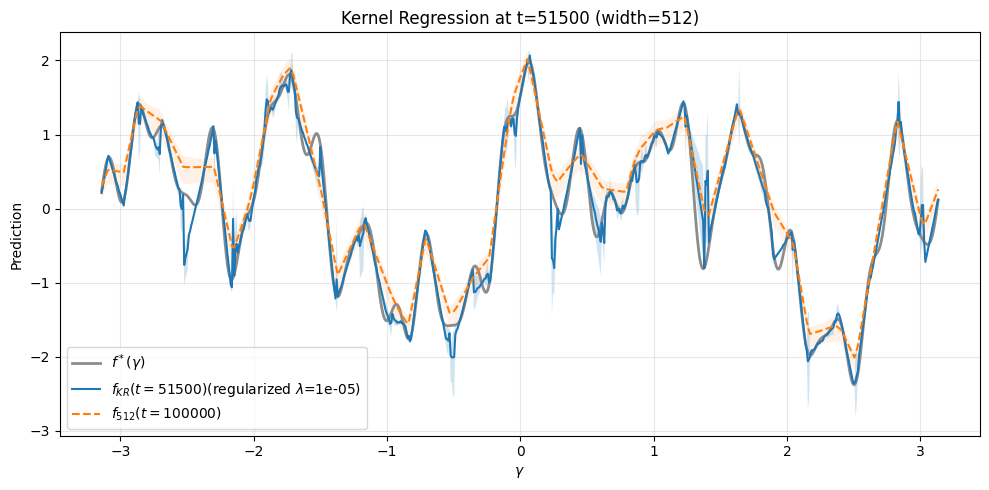


=== width=1024, KR step=115000 ===


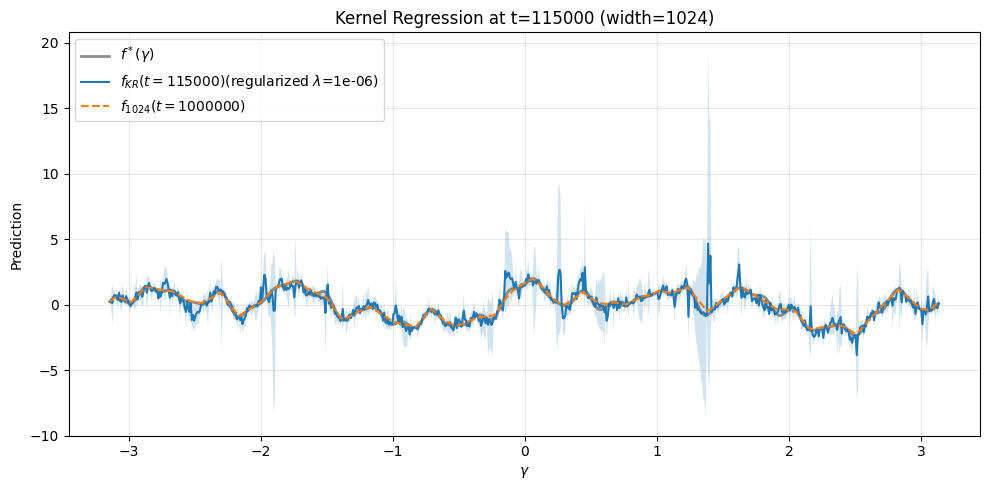


=== width=2048, KR step=310000 ===


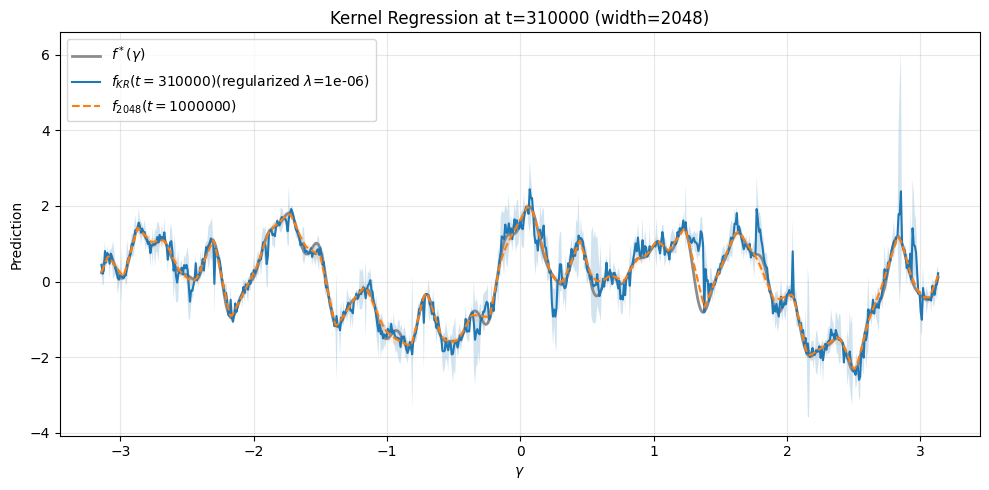

Skipping width 10000: no kr_step
Skipping width 10000: no kr_step


In [29]:
base_path = Path("plots") / "kernel_regression"
os.makedirs(base_path, exist_ok=True)

plot_kernel_regression_all(RUN_1, man_1, {w: freeze_steps[w] for w in widths_1}, reg=1e-5, save_path=base_path / "kernel_regression_low_widths.png")
plot_kernel_regression_all(RUN_2, man_2, {w: freeze_steps[w] for w in widths_2}, reg=1e-6, save_path=base_path / "kernel_regression_mid_widths.png")
plot_kernel_regression_all(RUN_3, man_3, {w: freeze_steps[w] for w in widths_3}, reg=1e-5, save_path=base_path / "kernel_regression_high_widths.png")

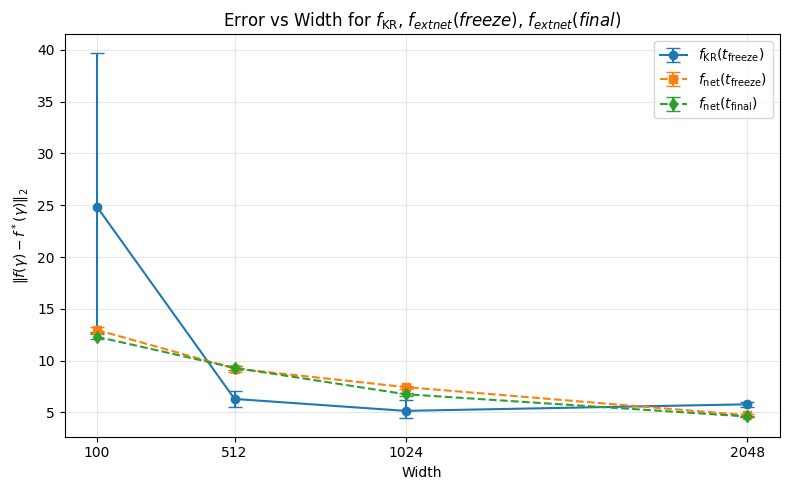

In [37]:
run_data_dict = {
    "run_1": (
        RUN_1,
        man_1,
        freeze_steps,
        widths_1   
    ),
    "run_2": (
        RUN_2,
        man_2,
        freeze_steps,
        widths_2,
    ),
    "run_3": (
        RUN_3,
        man_3,
        freeze_steps,
        widths_3,
    )
}

plot_error_vs_width_multi(run_data_dict, save_path=Path("plots") / "error_vs_width_combined.png", reg=1e-5)


# Fourier analysis on empirical NTKs

In [17]:
BASE = "../results"; EXP = "ntk_kernel_drift"
RUN = latest_run_dir(BASE, EXP)

In [18]:
man = load_manifest(RUN)
man

{'data_file': 'data_fourier.npz',
 'runs': {'100': 'runs/width_100.npz',
  '512': 'runs/width_512.npz',
  '1024': 'runs/width_1024.npz',
  '2048': 'runs/width_2048.npz',
  '10000': 'runs/width_10000.npz'},
 'meta': {'widths': [100, 512, 1024, 2048, 10000],
  'seeds': 5,
  'steps': 100000,
  'lr': 1.0,
  'eval_every': 500,
  'depth_hidden': 1,
  'M_train': 256,
  'n_eval': 720,
  'noise_std': 0.02},
 'runtime_sec': 1588.06}

In [40]:
data = npz(RUN, man["data_file"])
data.keys()

dict_keys(['gamma_eval', 'X_eval', 'y_eval_true', 'gamma_train', 'X_train', 'y_train', 'Ks', 'amps', 'phases'])

In [60]:
X_train = data["X_train"]
y_train = data["y_train"]
gamma_train = data["gamma_train"]
gamma_eval = data["gamma_eval"]

mask = np.isin(gamma_eval, gamma_train)
train_indices_in_eval = np.where(mask)[0]

print(f"{X_train.shape=}, {y_train.shape=}, {gamma_train.shape=}")
print(train_indices_in_eval)

X_train.shape=(256, 2), y_train.shape=(256,), gamma_train.shape=(256,)
[  0   1   4   5   6   8  12  13  16  18  19  20  24  25  30  31  34  35
  36  37  38  39  40  41  43  45  51  53  55  56  58  67  70  80  82  84
  86  88  90  96  98 102 104 109 110 112 114 119 120 124 125 130 132 136
 144 145 146 150 152 157 162 165 166 169 172 177 178 180 188 194 197 200
 201 203 204 207 209 210 217 218 219 221 226 228 234 235 239 245 250 259
 263 264 265 266 268 269 270 272 274 275 276 278 279 280 283 285 287 288
 291 292 299 305 308 309 310 311 312 317 318 319 327 333 334 336 339 340
 342 351 353 359 360 364 365 366 371 376 385 386 392 396 400 403 405 411
 413 415 416 418 419 420 430 433 435 436 438 441 442 445 449 451 452 453
 456 463 466 469 470 472 473 474 475 478 479 482 484 485 486 487 488 489
 491 493 495 498 501 503 504 518 522 526 528 529 530 531 537 538 539 543
 547 549 553 555 556 559 562 573 576 578 586 590 591 593 595 596 598 600
 604 606 609 613 617 621 622 630 636 637 639 640 646 

In [44]:
block = npz(RUN, man["runs"]["100"])
block.keys()

dict_keys(['K_train_train', 'K_eval_train', 'kernel_meta', 'preds', 'preds_meta', 'loss_meta', 'loss_values', 'X_train', 'y_train'])

In [49]:
seeds, Ktts, Kets = get_kernel_matrices_for_step(block, 1000)
print(f"{len(Ktts)=},{Ktts[0].shape=}")

len(Ktts)=5,Ktts[0].shape=(256, 256)


In [19]:
def mode_decay_over_time(run_dir, man, width, num_modes=5,
                         q_low=10, q_high=90):
    """
    For a given width, compute mode coefficients c_i(t) over time.
    
    Returns:
        steps_unique : (T_steps,)
        c_mean       : (T_steps, num_modes)
        c_lo         : (T_steps, num_modes)
        c_hi         : (T_steps, num_modes)
    """
    block = npz(run_dir, man["runs"][str(width)])
    preds = block["preds"]                 # (T_snap, N_train)
    preds_meta = block["preds_meta"]       # (T_snap, 2): (seed, step)

    K_all = block["K_train_train"]         # (T_snap, N_train, N_train)
    K_meta = block["kernel_meta"]          # (T_snap, 2): (seed, step)

    # training targets
    data = npz(run_dir, man["data_file"])
    gamma_train = data["gamma_train"]              # (N_train,)
    gamma_eval = data["gamma_eval"]
    y_train = data["y_train"]              # (N_train,)
    mask = np.isin(gamma_eval, gamma_train)
    train_indices_in_eval = np.where(mask)[0]

    steps_unique = np.sort(np.unique(K_meta[:, 1]))

    # outputs
    c_mean = []
    c_lo   = []
    c_hi   = []

    for step in steps_unique:
        # collect all seeds for this step
        mask_pred = (preds_meta[:, 1] == step)
        mask_K    = (K_meta[:, 1] == step)

        preds_step = preds[mask_pred]      # shape (n_seeds, N_train)
        K_step     = K_all[mask_K]         # shape (n_seeds, N_train, N_train)

        c_modes_seed = []  # list of (num_modes,) per seed

        # for each seed, compute projection c_i(t)
        for f_pred, Ktt in zip(preds_step, K_step):
            f_pred_train = f_pred[train_indices_in_eval]
            r = f_pred_train - y_train  # residual on train set

            # eigen-decomp (symmetric)
            evals, evecs = np.linalg.eigh(Ktt.squeeze())

            # sort descending
            idx = np.argsort(evals)[::-1]
            evals = evals[idx]
            evecs = evecs[:, idx]

            # top-k eigenvectors
            U_top = evecs[:, :num_modes]  # (N_train, num_modes)

            # projections c_i = u_i^T r
            c = U_top.T @ r               # (num_modes,)
            c_modes_seed.append(np.abs(c)) # take magnitude

        c_modes_seed = np.array(c_modes_seed)  # (n_seeds, num_modes)

        c_mean.append(c_modes_seed.mean(axis=0))
        lo, hi = np.percentile(c_modes_seed, [q_low, q_high], axis=0)
        c_lo.append(lo)
        c_hi.append(hi)

    return (
        steps_unique,
        np.array(c_mean),
        np.array(c_lo),
        np.array(c_hi)
    )


def plot_mode_decay_over_time(run_dir, man, width,
                              num_modes=5, q_low=10, q_high=90,
                              freeze_step=None, save_path=None):

    steps, c_mean, c_lo, c_hi = mode_decay_over_time(
        run_dir, man, width, num_modes=num_modes,
        q_low=q_low, q_high=q_high
    )

    plt.figure(figsize=(8, 5))

    for i in range(num_modes):
        plt.plot(steps, c_mean[:, i], label=rf"|c$_{i+1}$(t)|")
        plt.fill_between(steps, c_lo[:, i], c_hi[:, i], alpha=0.2)

    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Residual mode amplitude  |c_i(t)|")
    plt.title(f"Decay of top {num_modes} NTK modes (width={width})")

    # --- Add freeze-step vertical line ---
    if freeze_step is not None:
        plt.axvline(freeze_step, color="red", linestyle="--",
                    linewidth=2, alpha=0.8,
                    label=f"NTK freeze step = {freeze_step}")

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


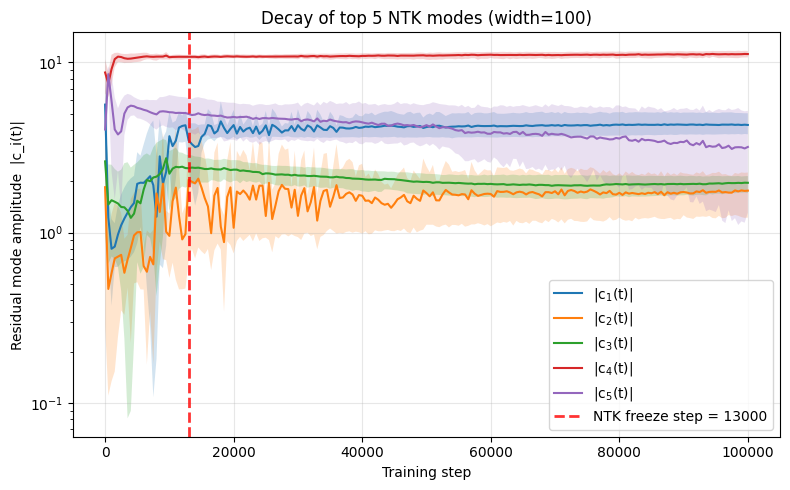

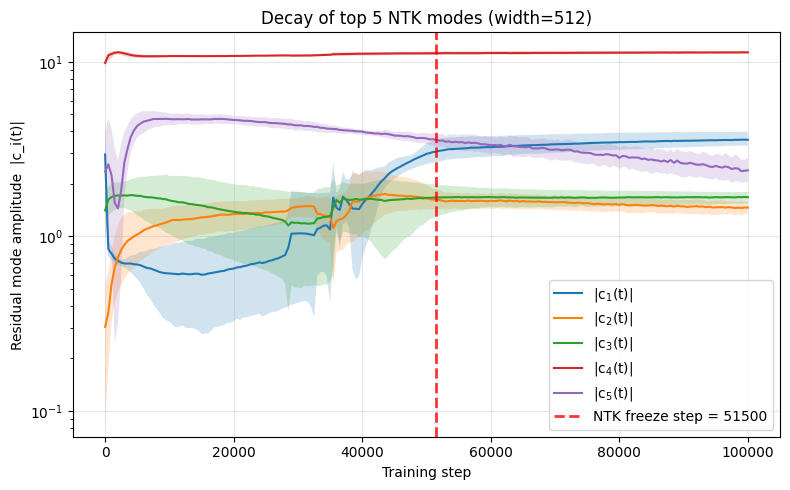

In [42]:
base_path = Path("plots") / "mode_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
plot_mode_decay_over_time(RUN, man, width=100, num_modes=5, freeze_step=freeze_steps[100], save_path=base_path / "mode_decay_w100.png")
plot_mode_decay_over_time(RUN, man, width=512, num_modes=5, freeze_step=freeze_steps[512], save_path=base_path / "mode_decay_w512.png")

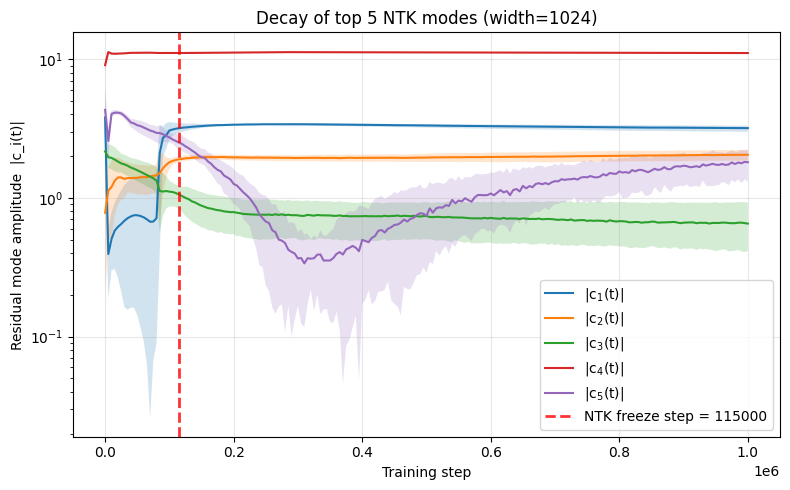

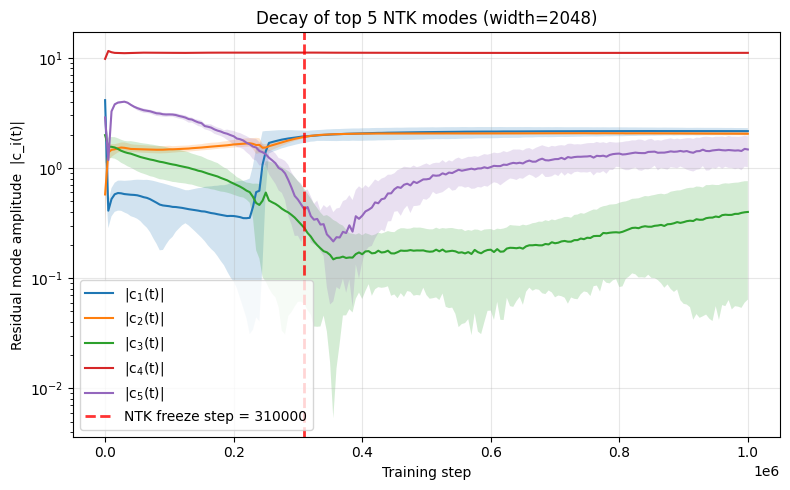

In [43]:
base_path = Path("plots") / "mode_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
plot_mode_decay_over_time(RUN, man, width=1024, num_modes=5, freeze_step=freeze_steps[1024], save_path=base_path / "mode_decay_w1024.png")
plot_mode_decay_over_time(RUN, man, width=2048, num_modes=5, freeze_step=freeze_steps[2048], save_path=base_path / "mode_decay_w2048.png")

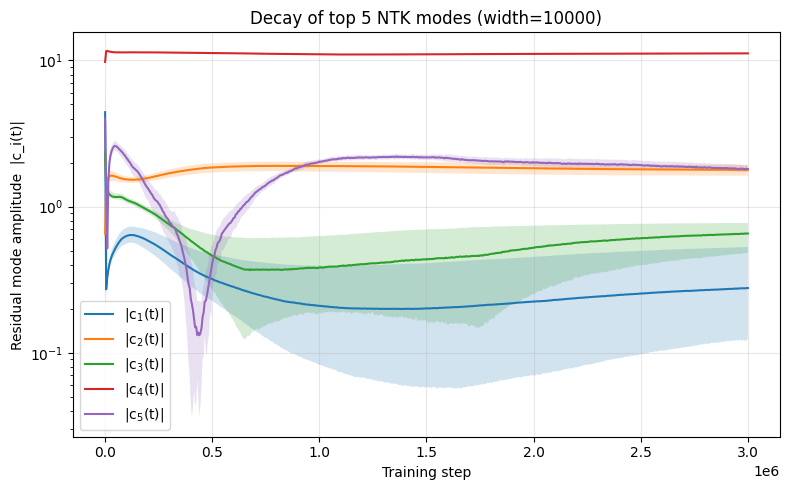

In [44]:
base_path = Path("plots") / "mode_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift_10000_more_steps"
RUN = latest_run_dir(BASE, EXP)
man= load_manifest(RUN)
plot_mode_decay_over_time(RUN, man, width=10000, num_modes=5, save_path=base_path / "mode_decay_w10000.png")

In [45]:
def build_mixture_basis(gamma_eval, Ks, phases):
    """
    gamma_eval : (M,)
    Ks         : list/array of frequencies (len = J)
    phases     : list/array of phases (len = J)

    Returns:
        B : (M, J) where column j is b_j(γ) = sin(K_j γ + φ_j)
        norms_sq : (J,) with ⟨b_j, b_j⟩ (discrete)
    """
    gamma = np.asarray(gamma_eval)
    Ks = np.asarray(Ks)
    phases = np.asarray(phases)

    cols = []
    for K, phi in zip(Ks, phases):
        b = np.sin(K * gamma + phi)
        cols.append(b)

    B = np.stack(cols, axis=1)          # (M, J)
    norms_sq = np.sum(B * B, axis=0)    # ⟨b_j, b_j⟩ per column

    return B, norms_sq

In [46]:
def mixture_basis_residual_over_time(run_dir, man, width,
                                     Ks, phases,
                                     q_low=10, q_high=90):
    """
    For given width, project residuals on eval circle onto the 7 mixture basis
    b_j(γ) = sin(K_j γ + φ_j) and track |coeff_j(t)| over time (mean ± spread).

    Returns:
        steps         : (T_steps,)
        coeff_mean    : (T_steps, J)
        coeff_lo      : (T_steps, J)
        coeff_hi      : (T_steps, J)
    """
    # Load eval geometry + target
    # data_probe = npz(run_dir, man["probe_geometry"])
    data = npz(run_dir, man["data_file"])
    gamma_eval = data["gamma_eval"]      # (M,)
    y_eval_true = data["y_eval_true"]    # (M,)

    # Basis from your 7 components (unscaled)
    B, norms_sq = build_mixture_basis(gamma_eval, Ks, phases)  # (M,J), (J,)

    block = npz(run_dir, man["runs"][str(width)])
    preds = block["preds"]          # (T_snap, M_eval)
    preds_meta = block["preds_meta"]  # (T_snap, 2): (seed, step)

    steps = np.sort(np.unique(preds_meta[:, 1]))
    J = len(Ks)

    coeff_mean = []
    coeff_lo   = []
    coeff_hi   = []

    for step in steps:
        mask = (preds_meta[:, 1] == step)
        preds_step = preds[mask]           # (n_seeds, M_eval)

        coeffs_seed = []

        for f_pred in preds_step:
            r = f_pred - y_eval_true       # residual on eval grid, (M,)

            # projections: c_j = ⟨r, b_j⟩ / ⟨b_j, b_j⟩
            numer = B.T @ r                # (J,)
            c = numer / norms_sq           # (J,)

            coeffs_seed.append(np.abs(c))  # magnitude along each basis vector

        coeffs_seed = np.asarray(coeffs_seed)  # (n_seeds, J)

        coeff_mean.append(coeffs_seed.mean(axis=0))
        lo, hi = np.percentile(coeffs_seed, [q_low, q_high], axis=0)
        coeff_lo.append(lo)
        coeff_hi.append(hi)

    return (
        steps,
        np.asarray(coeff_mean),  # (T_steps, J)
        np.asarray(coeff_lo),
        np.asarray(coeff_hi),
    )


In [47]:
def plot_mixture_component_decay(run_dir, man, width,
                                 Ks, phases,
                                 q_low=10, q_high=90,
                                 freeze_step=None,
                                 save_path=None):
    steps, c_mean, c_lo, c_hi = mixture_basis_residual_over_time(
        run_dir, man, width, Ks, phases, q_low=q_low, q_high=q_high
    )

    J = len(Ks)
    plt.figure(figsize=(8, 5))

    for j in range(J):
        K = Ks[j]
        plt.plot(steps, c_mean[:, j], label=fr"k={K}")
        plt.fill_between(steps, c_lo[:, j], c_hi[:, j], alpha=0.2)

    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel(r"Residual amplitude along component $j$ ")
    plt.title(f"Decay of 7 mixture components (width={width})")
    plt.grid(alpha=0.3)

    if freeze_step is not None:
        plt.axvline(freeze_step, color="red", linestyle="--", linewidth=2,
                    alpha=0.8, label=f"freeze @ {freeze_step}")

    plt.legend(title="Fourier freq", fontsize=9)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [36]:
data = npz(RUN, man["data_file"])
data.keys()

dict_keys(['gamma_eval', 'X_eval', 'y_eval_true', 'gamma_train', 'X_train', 'y_train', 'Ks', 'amps', 'phases'])

In [38]:
Ks = data["Ks"]
amps = data["amps"]
phases = data["phases"]

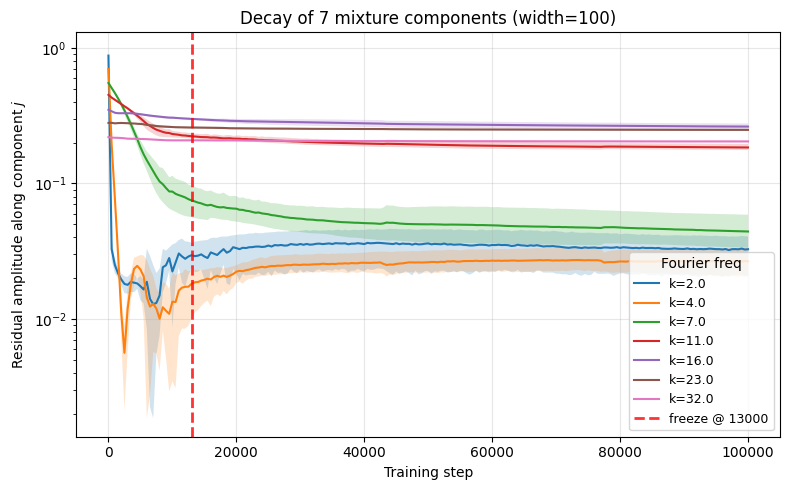

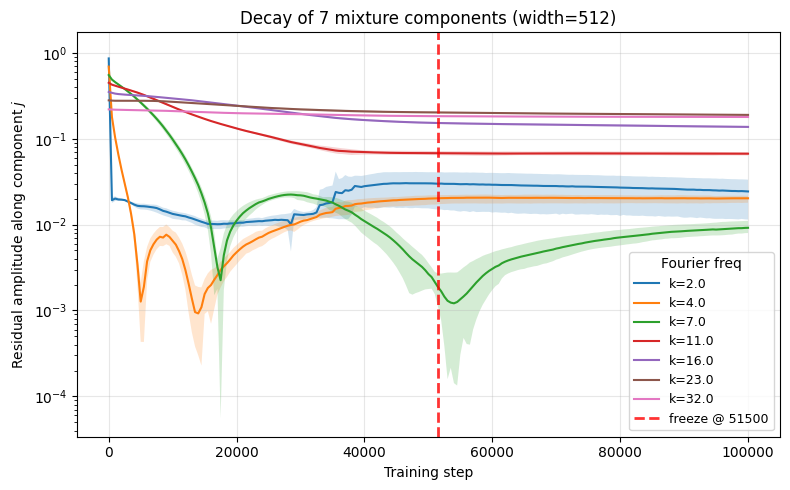

In [48]:
base_path = Path("plots") / "fourier_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
for width in [100, 512]:
    plot_mixture_component_decay(RUN, man, width, Ks=Ks, phases=phases,
                                 freeze_step=freeze_steps[width], save_path=base_path / f"fourier_decay_w{width}.png")

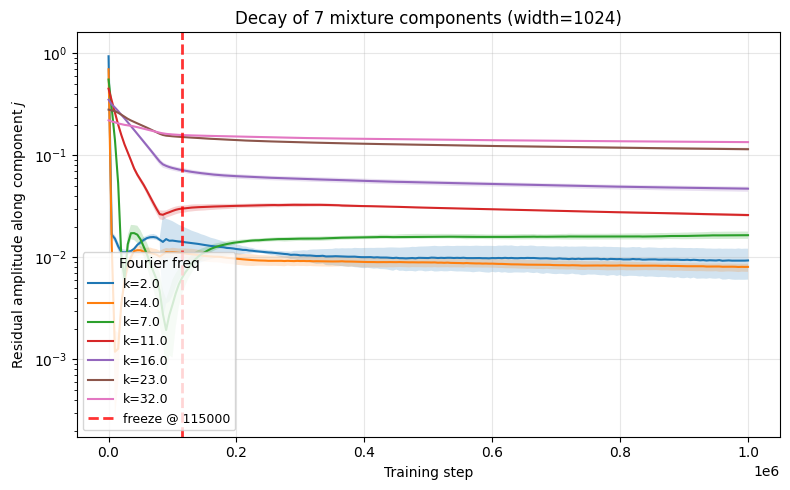

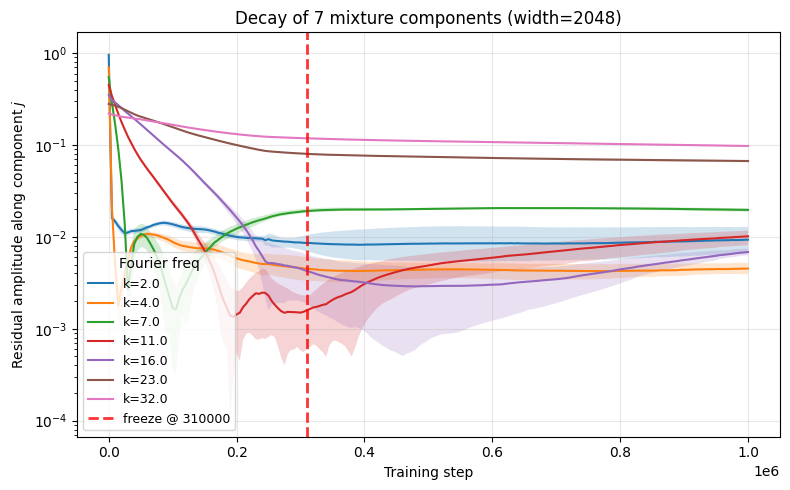

In [49]:
BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
for width in [1024, 2048]:
    plot_mixture_component_decay(RUN, man, width, Ks=Ks, phases=phases,
                                 freeze_step=freeze_steps[width], save_path=base_path / f"fourier_decay_w{width}.png")

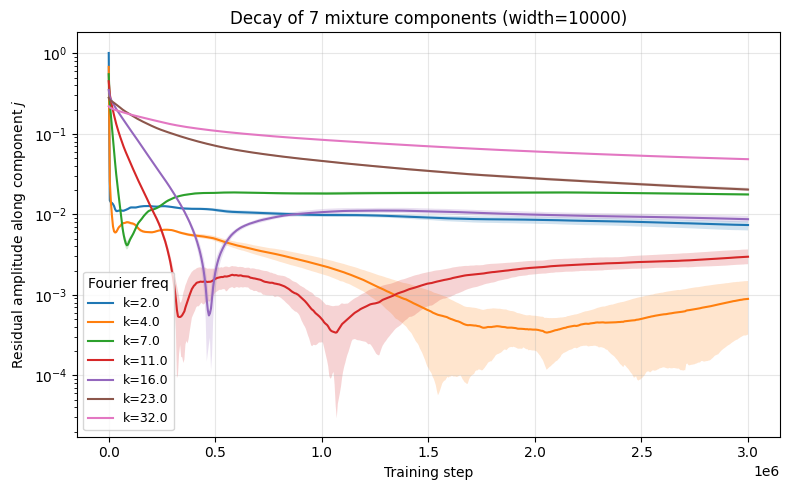

In [50]:
BASE = "../results"; EXP = "ntk_kernel_drift_10000_more_steps"
RUN = latest_run_dir(BASE, EXP)
man= load_manifest(RUN)
for width in [10000]:
    plot_mixture_component_decay(RUN, man, width, Ks=Ks, phases=phases, save_path=base_path / f"fourier_decay_w{width}.png")